In [1]:
import pandas as pd
import numpy as np
from pathlib2 import Path
import matplotlib.pyplot as plt
from typing import List, Tuple, Optional
import re
import lightgbm as lgb
from datetime import datetime
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score

import xgboost as xgb
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

In [2]:
def evraz_metric(true_t, predict_t, true_c, predict_c):

    delta_c = np.abs(np.array(true_c) - np.array(predict_c))
    hit_rate_c = np.int64(delta_c < 0.02)

    delta_t = np.abs(np.array(true_t) - np.array(predict_t))
    hit_rate_t = np.int64(delta_t < 20)

    N = np.size(predict_c)

    return np.sum(hit_rate_c + hit_rate_t) / 2 / N

In [3]:
path = Path('../../../data/2021_evraz')

In [4]:
target_train = pd.read_pickle(path.joinpath('target_train_all.pkl'))
print(target_train.shape)
target_train.head(3)

(2063, 167)


,NPLV,TST,C,VES,T_x,SI,MN,S,P,CR,...,NMSYP_Dolomsyr,NMSYP_Ugol_TO,NMSYP_FLUMAG,NMSYP_FlusFOMI,NMSYP_agl_ofl_s,NMSYP_dolom_syr,NMSYP_izvotsev,NMSYP_izv_ZOI,NMSYP_izv_otsev,NMSYP_koks_25_40
0,510008,1690,0.060,263700.0,1396.0,0.44,0.22,0.023,0.097,0.03,...,0,2950,2960,980,0,0,0,14080,0,0
1,510009,1683,0.097,264500.0,1419.0,0.68,0.20,0.017,0.087,0.02,...,0,2930,0,960,0,0,1060,18830,0,0
2,510010,1662,0.091,263800.0,1384.0,0.56,0.26,0.017,0.096,0.03,...,0,2990,2960,1050,0,0,990,16080,0,0


In [5]:
test = pd.read_pickle(path.joinpath('test_all.pkl'))
print(test.shape)
test.head(3)

(780, 165)


,NPLV,VES,T_x,SI,MN,S,P,CR,NI,CU,...,NMSYP_Dolomsyr,NMSYP_Ugol_TO,NMSYP_FLUMAG,NMSYP_FlusFOMI,NMSYP_agl_ofl_s,NMSYP_dolom_syr,NMSYP_izvotsev,NMSYP_izv_ZOI,NMSYP_izv_otsev,NMSYP_koks_25_40
0,512324,240100.0,1355.0,0.46,0.33,0.027,0.079,0.01,0.01,0.02,...,0,1310,1670,0,0,0,0,13960,0,0
1,512327,266400.0,1390.0,0.30,0.33,0.032,0.099,0.01,0.00,0.00,...,0,0,0,0,0,0,0,15290,0,50
2,512328,270200.0,1373.0,0.00,0.00,0.000,0.000,0.00,0.00,0.00,...,0,0,0,0,0,0,0,20010,0,1400


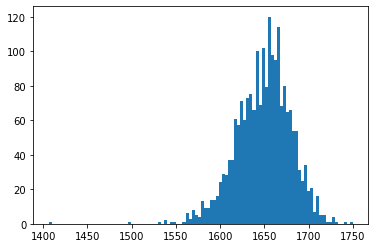

In [7]:
plt.hist(target_train['TST'], bins=100);

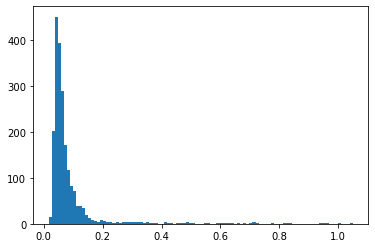

In [6]:
plt.hist(target_train['C'], bins=100);

**Сделаем логарифмирование целевой функции С.**

In [7]:
# target_train = pd.read_pickle(path.joinpath('target_train_all.pkl'))
# target_train['C'] = np.log10(target_train['C'])

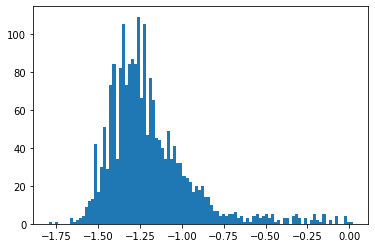

In [8]:
plt.hist(target_train['C'], bins=100);

In [15]:
target_train = pd.read_pickle(path.joinpath('target_train_all.pkl'))
target_train['C'] = np.log(target_train['C'])

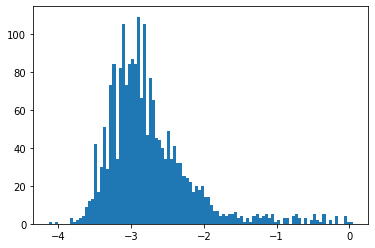

In [16]:
plt.hist(target_train['C'], bins=100);

In [35]:
# target_train = pd.read_pickle(path.joinpath('target_train_all.pkl'))
# target_train['C'] = np.log2(target_train['C'])

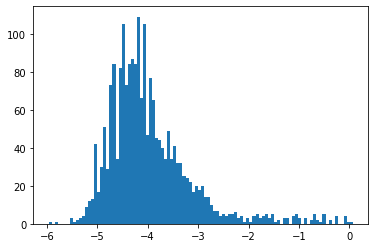

In [36]:
plt.hist(target_train['C'], bins=100);

In [9]:
target_train['C']

0      -1.221849
1      -1.013228
2      -1.040959
3      -0.387216
4      -0.920819
          ...   
2058   -0.838632
2059   -1.060481
2060   -0.850781
2061   -0.568636
2062   -0.737549
Name: C, Length: 2063, dtype: float64

In [17]:
def make_cross_validation(X: pd.DataFrame,
                          y_1: pd.Series,
                          y_2: pd.Series,
                          X_test: pd.DataFrame,
                          estimator_1: object,
                          estimator_2: object,
                          metric: callable,
                          cv_strategy,
                          error_to_be_outlier: None):
    """
    Кросс-валидация.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y_1: pd.Series
        Вектор 1-й целевой переменной.
        
    y_2: pd.Series
        Вектор 2-й целевой переменной.
        
    X_test: pd.Series
        Матрица признаков для предсказания.

    estimator: callable
        Объект модели для обучения.

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.
        
    error_to_be_outlier: float, optional, default = None
        Максимальная относительная величина ошибки для того,
        чтобы объект считать выбросом и не учитывать в итоговой
        ошибке алгоритма. Опциональный параметр, по умолчанию,
        не используется.
        Если ставим 100, это 100% - если 2 раза ошибаемся, то
        говорим, что это выброс.

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах.

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    estimators, fold_train_scores_1, fold_train_scores_2, fold_valid_scores_1, fold_valid_scores_2, \
    evraz_metric_train_scores, evraz_metric_valid_scores = [], [], [], [], [], [], []
    oof_predictions_1, oof_predictions_2 = np.zeros(X.shape[0]), np.zeros(X.shape[0])

    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y_1)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train_1, y_valid_1 = y_1.loc[train_idx], y_1.loc[valid_idx]
        y_train_2, y_valid_2 = y_2.loc[train_idx], y_2.loc[valid_idx]

        estimator_1.fit(x_train, y_train_1)
        estimator_2.fit(x_train, y_train_2)
        y_train_pred_1 = estimator_1.predict(x_train)
        y_train_pred_2 = estimator_2.predict(x_train)
        y_valid_pred_1 = estimator_1.predict(x_valid)
        y_valid_pred_2 = estimator_2.predict(x_valid)

        fold_train_scores_1.append(metric(y_train_1, y_train_pred_1))
        fold_train_scores_2.append(metric(y_train_2, y_train_pred_2))
        
        if not error_to_be_outlier:
            fold_valid_scores_1.append(metric(y_valid_1, y_valid_pred_1))
            fold_valid_scores_2.append(metric(y_valid_2, y_valid_pred_2))
        else:
            mask = ((y_valid_1 - y_valid_pred_1) / y_valid_1) < error_to_be_outlier
            fold_valid_scores_1.append(metric(y_valid_1.loc[mask], y_valid_pred_1[mask]))
            mask = ((y_valid_2 - y_valid_pred_2) / y_valid_2) < error_to_be_outlier
            fold_valid_scores_2.append(metric(y_valid_2.loc[mask], y_valid_pred_2[mask]))
            
        oof_predictions_1[valid_idx] = y_valid_pred_1
        oof_predictions_2[valid_idx] = y_valid_pred_2
        
        evraz_metric_train = evraz_metric(y_train_1, y_train_pred_1, y_train_2, y_train_pred_2)
        evraz_metric_valid = evraz_metric(y_valid_1, y_valid_pred_1, y_valid_2, y_valid_pred_2)
        evraz_metric_train_scores.append(evraz_metric_train)
        evraz_metric_valid_scores.append(evraz_metric_valid)

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score 1 = {round(fold_train_scores_1[fold_number], 4)}, "
            f"train-score 2 = {round(fold_train_scores_2[fold_number], 4)}\n"
            f"valid-score 1 = {round(fold_valid_scores_1[fold_number], 4)}, "
            f"valid-score 2 = {round(fold_valid_scores_2[fold_number], 4)}" 
        )
        print(msg)
        print('Train metric = ', round(evraz_metric_train, 4))
        print('Valid metric = ', round(evraz_metric_valid, 4))
        print("="*69)
        estimators.append(estimator_1)
        estimators.append(estimator_2)

    if not error_to_be_outlier:
        oof_score_1 = metric(y_1, oof_predictions_1)
        oof_score_2 = metric(y_2, oof_predictions_2)
    else:
        mask = ((y_1 - oof_predictions_1) / y_1) < error_to_be_outlier
        oof_score_1 = metric(y_1.loc[mask], oof_predictions_1[mask])
        mask = ((y_2 - oof_predictions_2) / y_1) < error_to_be_outlier
        oof_score_2 = metric(y_2.loc[mask], oof_predictions_2[mask])
        
    print(f"CV-results train 1: {round(np.mean(fold_train_scores_1), 4)} +/- {round(np.std(fold_train_scores_1), 3)}")
    print(f"CV-results train 2: {round(np.mean(fold_train_scores_2), 4)} +/- {round(np.std(fold_train_scores_2), 3)}")
    print(f"CV-results valid 1: {round(np.mean(fold_valid_scores_1), 4)} +/- {round(np.std(fold_valid_scores_1), 3)}")
    print(f"CV-results valid 2: {round(np.mean(fold_valid_scores_2), 4)} +/- {round(np.std(fold_valid_scores_2), 3)}")
    print(f"OOF-score 1 = {round(oof_score_1, 4)}")
    print(f"OOF-score 2 = {round(oof_score_2, 4)}")
    
    print(f"CV-results evraz metric train: {round(np.mean(evraz_metric_train_scores), 4)}\
+/- {round(np.std(evraz_metric_train_scores), 3)}")
    print(f"CV-results evraz metric valid: {round(np.mean(evraz_metric_valid_scores), 4)}\
+/- {round(np.std(evraz_metric_valid_scores), 3)}")
    
    # error fix: ValueError: Feature shape mismatch, expected: 142, got 780
    # https://stackoverflow.com/questions/42338972/valueerror-feature-names-mismatch-in-xgboost-in-the-predict-function
    f_names = estimator_1.get_booster().feature_names 
    X_test = X_test[f_names]
    
    return estimators, oof_score_1, oof_score_2, fold_train_scores_1, fold_train_scores_2, fold_valid_scores_1,\
fold_valid_scores_2, oof_predictions_1, oof_predictions_2, estimator_1.predict(X_test), estimator_2.predict(X_test),\
np.mean(evraz_metric_train_scores), np.mean(evraz_metric_valid_scores)

In [ ]:
plt.plot(n_trees, oof_score_1)
plt.plot(n_trees, oof_score_2)
plt.xlabel('n_estimators')
plt.ylabel('score')
plt.show();

  0%|                                                                                           | 0/95 [00:00<?, ?it/s]

Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 2.9446, train-score 2 = 0.0005
valid-score 1 = 603.2629, valid-score 2 = 0.2086
Train metric =  0.84
Valid metric =  0.3366
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 2.42, train-score 2 = 0.0005
valid-score 1 = 439.3116, valid-score 2 = 0.1657
Train metric =  0.8618
Valid metric =  0.3862
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 3.0052, train-score 2 = 0.0006
valid-score 1 = 510.3918, valid-score 2 = 0.1845
Train metric =  0.8342
Valid metric =  0.3826
Fold: 4, train-observations = 1651, valid-observations = 412
train-score 1 = 2.1468, train-score 2 = 0.0005
valid-score 1 = 473.2893, valid-score 2 = 0.1397
Train metric =  0.8586
Valid metric =  0.3835


  1%|▊                                                                                  | 1/95 [00:05<08:50,  5.64s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 2.3265, train-score 2 = 0.0007
valid-score 1 = 440.5067, valid-score 2 = 0.1541
Train metric =  0.8362
Valid metric =  0.3677
CV-results train 1: 2.5686 +/- 0.344
CV-results train 2: 0.0006 +/- 0.0
CV-results valid 1: 493.3524 +/- 60.805
CV-results valid 2: 0.1705 +/- 0.024
OOF-score 1 = 493.3878
OOF-score 2 = 0.1705
CV-results evraz metric train: 0.8462+/- 0.012
CV-results evraz metric valid: 0.3713+/- 0.019
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 3.1147, train-score 2 = 0.0005
valid-score 1 = 602.9791, valid-score 2 = 0.2084
Train metric =  0.8342
Valid metric =  0.3341
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 2.4372, train-score 2 = 0.0005
valid-score 1 = 439.0349, valid-score 2 = 0.1658
Train metric =  0.8609
Valid metric =  0.385
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 3.1225, train-score 2 = 0.00

  2%|█▋                                                                                 | 2/95 [00:11<08:55,  5.76s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 2.492, train-score 2 = 0.0007
valid-score 1 = 440.1327, valid-score 2 = 0.1539
Train metric =  0.8325
Valid metric =  0.3677
CV-results train 1: 2.6721 +/- 0.378
CV-results train 2: 0.0006 +/- 0.0
CV-results valid 1: 493.1507 +/- 60.802
CV-results valid 2: 0.1705 +/- 0.024
OOF-score 1 = 493.186
OOF-score 2 = 0.1705
CV-results evraz metric train: 0.8425+/- 0.013
CV-results evraz metric valid: 0.3706+/- 0.019
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 3.1804, train-score 2 = 0.0006
valid-score 1 = 602.9051, valid-score 2 = 0.2086
Train metric =  0.8285
Valid metric =  0.3354
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 2.5335, train-score 2 = 0.0005
valid-score 1 = 438.7352, valid-score 2 = 0.1658
Train metric =  0.8552
Valid metric =  0.3838
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 3.1676, train-score 2 = 0.000

  3%|██▌                                                                                | 3/95 [00:17<09:03,  5.90s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 2.7076, train-score 2 = 0.0007
valid-score 1 = 439.5557, valid-score 2 = 0.1539
Train metric =  0.8283
Valid metric =  0.3677
CV-results train 1: 2.7742 +/- 0.353
CV-results train 2: 0.0006 +/- 0.0
CV-results valid 1: 492.973 +/- 60.924
CV-results valid 2: 0.1704 +/- 0.024
OOF-score 1 = 493.0083
OOF-score 2 = 0.1705
CV-results evraz metric train: 0.8368+/- 0.013
CV-results evraz metric valid: 0.3701+/- 0.018
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 3.3956, train-score 2 = 0.0006
valid-score 1 = 605.2643, valid-score 2 = 0.2083
Train metric =  0.8242
Valid metric =  0.3354
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 2.6366, train-score 2 = 0.0006
valid-score 1 = 438.8829, valid-score 2 = 0.1657
Train metric =  0.8518
Valid metric =  0.3838
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 3.2312, train-score 2 = 0.00

  4%|███▍                                                                               | 4/95 [00:23<08:57,  5.90s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 2.9806, train-score 2 = 0.0008
valid-score 1 = 438.04, valid-score 2 = 0.1539
Train metric =  0.8186
Valid metric =  0.3677
CV-results train 1: 2.9165 +/- 0.386
CV-results train 2: 0.0006 +/- 0.0
CV-results valid 1: 493.239 +/- 62.009
CV-results valid 2: 0.1703 +/- 0.024
OOF-score 1 = 493.2752
OOF-score 2 = 0.1704
CV-results evraz metric train: 0.8313+/- 0.013
CV-results evraz metric valid: 0.3699+/- 0.018
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 3.6827, train-score 2 = 0.0006
valid-score 1 = 605.7186, valid-score 2 = 0.2084
Train metric =  0.8203
Valid metric =  0.3341
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 2.7238, train-score 2 = 0.0006
valid-score 1 = 439.0775, valid-score 2 = 0.1658
Train metric =  0.8497
Valid metric =  0.3838
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 3.3729, train-score 2 = 0.0007

  5%|████▎                                                                              | 5/95 [00:29<08:48,  5.87s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 3.0876, train-score 2 = 0.0008
valid-score 1 = 437.9271, valid-score 2 = 0.1537
Train metric =  0.8101
Valid metric =  0.3689
CV-results train 1: 3.0624 +/- 0.442
CV-results train 2: 0.0007 +/- 0.0
CV-results valid 1: 493.289 +/- 62.167
CV-results valid 2: 0.1703 +/- 0.024
OOF-score 1 = 493.3255
OOF-score 2 = 0.1703
CV-results evraz metric train: 0.8283+/- 0.015
CV-results evraz metric valid: 0.3696+/- 0.018
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 3.8915, train-score 2 = 0.0006
valid-score 1 = 606.1905, valid-score 2 = 0.2084
Train metric =  0.817
Valid metric =  0.3317
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 2.8509, train-score 2 = 0.0006
valid-score 1 = 439.5408, valid-score 2 = 0.1658
Train metric =  0.8415
Valid metric =  0.3838
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 3.5538, train-score 2 = 0.000

  6%|█████▏                                                                             | 6/95 [00:35<08:39,  5.84s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 3.1548, train-score 2 = 0.0009
valid-score 1 = 438.2164, valid-score 2 = 0.1538
Train metric =  0.8077
Valid metric =  0.3689
CV-results train 1: 3.2025 +/- 0.476
CV-results train 2: 0.0007 +/- 0.0
CV-results valid 1: 493.563 +/- 62.234
CV-results valid 2: 0.1703 +/- 0.024
OOF-score 1 = 493.5997
OOF-score 2 = 0.1703
CV-results evraz metric train: 0.8236+/- 0.013
CV-results evraz metric valid: 0.3694+/- 0.02
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 4.0431, train-score 2 = 0.0007
valid-score 1 = 606.8439, valid-score 2 = 0.2087
Train metric =  0.8091
Valid metric =  0.3329
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 3.0022, train-score 2 = 0.0006
valid-score 1 = 440.0505, valid-score 2 = 0.1657
Train metric =  0.8385
Valid metric =  0.3838
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 3.6647, train-score 2 = 0.000

  7%|██████                                                                             | 7/95 [00:41<08:38,  5.89s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 3.2151, train-score 2 = 0.0009
valid-score 1 = 441.2003, valid-score 2 = 0.1537
Train metric =  0.8038
Valid metric =  0.3689
CV-results train 1: 3.3173 +/- 0.487
CV-results train 2: 0.0007 +/- 0.0
CV-results valid 1: 494.3148 +/- 61.847
CV-results valid 2: 0.1703 +/- 0.024
OOF-score 1 = 494.3508
OOF-score 2 = 0.1703
CV-results evraz metric train: 0.818+/- 0.013
CV-results evraz metric valid: 0.3699+/- 0.019
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 4.27, train-score 2 = 0.0007
valid-score 1 = 606.8245, valid-score 2 = 0.2089
Train metric =  0.8012
Valid metric =  0.3317
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 3.2498, train-score 2 = 0.0007
valid-score 1 = 440.0603, valid-score 2 = 0.1656
Train metric =  0.8315
Valid metric =  0.385
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 3.7985, train-score 2 = 0.0009


  8%|██████▉                                                                            | 8/95 [00:46<08:29,  5.86s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 3.4645, train-score 2 = 0.001
valid-score 1 = 441.4813, valid-score 2 = 0.1536
Train metric =  0.7941
Valid metric =  0.3677
CV-results train 1: 3.5199 +/- 0.492
CV-results train 2: 0.0008 +/- 0.0
CV-results valid 1: 494.2781 +/- 61.772
CV-results valid 2: 0.1703 +/- 0.024
OOF-score 1 = 494.3139
OOF-score 2 = 0.1703
CV-results evraz metric train: 0.8108+/- 0.015
CV-results evraz metric valid: 0.3701+/- 0.02
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 4.3287, train-score 2 = 0.0008
valid-score 1 = 609.8442, valid-score 2 = 0.2086
Train metric =  0.7976
Valid metric =  0.3305
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 3.4234, train-score 2 = 0.0007
valid-score 1 = 440.0229, valid-score 2 = 0.1656
Train metric =  0.8282
Valid metric =  0.385
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 3.8764, train-score 2 = 0.0009

  9%|███████▊                                                                           | 9/95 [00:52<08:24,  5.87s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 3.6227, train-score 2 = 0.0011
valid-score 1 = 441.3116, valid-score 2 = 0.1537
Train metric =  0.7886
Valid metric =  0.3665
CV-results train 1: 3.6234 +/- 0.485
CV-results train 2: 0.0008 +/- 0.0
CV-results valid 1: 494.8799 +/- 62.887
CV-results valid 2: 0.1703 +/- 0.024
OOF-score 1 = 494.9162
OOF-score 2 = 0.1704
CV-results evraz metric train: 0.805+/- 0.014
CV-results evraz metric valid: 0.3689+/- 0.02
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 4.4466, train-score 2 = 0.0008
valid-score 1 = 609.1044, valid-score 2 = 0.2087
Train metric =  0.7852
Valid metric =  0.3317
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 3.5393, train-score 2 = 0.0007
valid-score 1 = 439.9532, valid-score 2 = 0.1656
Train metric =  0.8245
Valid metric =  0.3838
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 4.1326, train-score 2 = 0.000

 11%|████████▋                                                                         | 10/95 [00:59<08:52,  6.26s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 3.7815, train-score 2 = 0.0012
valid-score 1 = 441.4981, valid-score 2 = 0.1537
Train metric =  0.7856
Valid metric =  0.3701
CV-results train 1: 3.7966 +/- 0.471
CV-results train 2: 0.0009 +/- 0.0
CV-results valid 1: 494.6044 +/- 62.569
CV-results valid 2: 0.1703 +/- 0.024
OOF-score 1 = 494.6404
OOF-score 2 = 0.1704
CV-results evraz metric train: 0.7997+/- 0.015
CV-results evraz metric valid: 0.3696+/- 0.02
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 4.5974, train-score 2 = 0.0009
valid-score 1 = 609.1739, valid-score 2 = 0.2088
Train metric =  0.7815
Valid metric =  0.3305
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 3.7336, train-score 2 = 0.0008
valid-score 1 = 439.6546, valid-score 2 = 0.1657
Train metric =  0.8203
Valid metric =  0.3838
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 4.2889, train-score 2 = 0.00

 12%|█████████▍                                                                        | 11/95 [01:06<08:51,  6.33s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 3.88, train-score 2 = 0.0013
valid-score 1 = 441.9588, valid-score 2 = 0.1539
Train metric =  0.7777
Valid metric =  0.3701
CV-results train 1: 3.9445 +/- 0.472
CV-results train 2: 0.0009 +/- 0.0
CV-results valid 1: 494.7283 +/- 62.561
CV-results valid 2: 0.1705 +/- 0.024
OOF-score 1 = 494.7641
OOF-score 2 = 0.1705
CV-results evraz metric train: 0.7952+/- 0.016
CV-results evraz metric valid: 0.3699+/- 0.02
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 4.6785, train-score 2 = 0.0009
valid-score 1 = 609.3311, valid-score 2 = 0.209
Train metric =  0.7779
Valid metric =  0.3281
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 3.8923, train-score 2 = 0.0008
valid-score 1 = 439.7251, valid-score 2 = 0.1657
Train metric =  0.8145
Valid metric =  0.3838
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 4.3882, train-score 2 = 0.001
v

 13%|██████████▎                                                                       | 12/95 [01:12<08:30,  6.15s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 4.1965, train-score 2 = 0.0013
valid-score 1 = 442.2342, valid-score 2 = 0.1539
Train metric =  0.7765
Valid metric =  0.3689
CV-results train 1: 4.0962 +/- 0.463
CV-results train 2: 0.001 +/- 0.0
CV-results valid 1: 494.7943 +/- 62.547
CV-results valid 2: 0.1705 +/- 0.024
OOF-score 1 = 494.83
OOF-score 2 = 0.1705
CV-results evraz metric train: 0.7919+/- 0.015
CV-results evraz metric valid: 0.3706+/- 0.022
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 4.8058, train-score 2 = 0.0009
valid-score 1 = 608.9913, valid-score 2 = 0.209
Train metric =  0.777
Valid metric =  0.3281
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 3.9555, train-score 2 = 0.0008
valid-score 1 = 439.7154, valid-score 2 = 0.1656
Train metric =  0.8103
Valid metric =  0.3838
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 4.6137, train-score 2 = 0.001
va

 14%|███████████▏                                                                      | 13/95 [01:17<08:13,  6.02s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 4.4056, train-score 2 = 0.0014
valid-score 1 = 441.0686, valid-score 2 = 0.1542
Train metric =  0.7698
Valid metric =  0.3701
CV-results train 1: 4.2548 +/- 0.474
CV-results train 2: 0.001 +/- 0.0
CV-results valid 1: 494.5342 +/- 62.604
CV-results valid 2: 0.1705 +/- 0.024
OOF-score 1 = 494.5701
OOF-score 2 = 0.1705
CV-results evraz metric train: 0.7888+/- 0.015
CV-results evraz metric valid: 0.3708+/- 0.022
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 5.0162, train-score 2 = 0.001
valid-score 1 = 608.7879, valid-score 2 = 0.2092
Train metric =  0.7715
Valid metric =  0.3257
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 3.9926, train-score 2 = 0.0009
valid-score 1 = 439.73, valid-score 2 = 0.1658
Train metric =  0.8027
Valid metric =  0.3838
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 4.7216, train-score 2 = 0.0011


 15%|████████████                                                                      | 14/95 [01:23<07:58,  5.91s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 4.4861, train-score 2 = 0.0014
valid-score 1 = 440.623, valid-score 2 = 0.1543
Train metric =  0.7674
Valid metric =  0.3701
CV-results train 1: 4.3922 +/- 0.466
CV-results train 2: 0.0011 +/- 0.0
CV-results valid 1: 494.3846 +/- 62.613
CV-results valid 2: 0.1706 +/- 0.024
OOF-score 1 = 494.4207
OOF-score 2 = 0.1707
CV-results evraz metric train: 0.7847+/- 0.014
CV-results evraz metric valid: 0.3701+/- 0.023
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 5.2125, train-score 2 = 0.0011
valid-score 1 = 608.4988, valid-score 2 = 0.2091
Train metric =  0.7615
Valid metric =  0.3281
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 4.1761, train-score 2 = 0.0009
valid-score 1 = 440.5947, valid-score 2 = 0.166
Train metric =  0.7955
Valid metric =  0.3838
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 5.0408, train-score 2 = 0.001

 16%|████████████▉                                                                     | 15/95 [01:29<07:45,  5.82s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 4.561, train-score 2 = 0.0015
valid-score 1 = 440.5574, valid-score 2 = 0.1541
Train metric =  0.7641
Valid metric =  0.3689
CV-results train 1: 4.563 +/- 0.519
CV-results train 2: 0.0011 +/- 0.0
CV-results valid 1: 494.5493 +/- 62.36
CV-results valid 2: 0.1706 +/- 0.024
OOF-score 1 = 494.5854
OOF-score 2 = 0.1706
CV-results evraz metric train: 0.7788+/- 0.014
CV-results evraz metric valid: 0.3686+/- 0.021
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 5.4489, train-score 2 = 0.0011
valid-score 1 = 609.2951, valid-score 2 = 0.209
Train metric =  0.7582
Valid metric =  0.3281
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 4.471, train-score 2 = 0.001
valid-score 1 = 441.0254, valid-score 2 = 0.1659
Train metric =  0.7912
Valid metric =  0.3826
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 5.2701, train-score 2 = 0.0012
va

 17%|█████████████▊                                                                    | 16/95 [01:35<07:42,  5.86s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 4.9222, train-score 2 = 0.0015
valid-score 1 = 440.3082, valid-score 2 = 0.1541
Train metric =  0.7641
Valid metric =  0.3689
CV-results train 1: 4.811 +/- 0.548
CV-results train 2: 0.0012 +/- 0.0
CV-results valid 1: 494.8298 +/- 62.614
CV-results valid 2: 0.1706 +/- 0.024
OOF-score 1 = 494.8662
OOF-score 2 = 0.1706
CV-results evraz metric train: 0.7751+/- 0.012
CV-results evraz metric valid: 0.3691+/- 0.021
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 5.7807, train-score 2 = 0.0012
valid-score 1 = 609.8131, valid-score 2 = 0.2089
Train metric =  0.7512
Valid metric =  0.3293
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 4.7532, train-score 2 = 0.001
valid-score 1 = 441.0099, valid-score 2 = 0.1657
Train metric =  0.7858
Valid metric =  0.3826
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 5.4905, train-score 2 = 0.001

 18%|██████████████▋                                                                   | 17/95 [01:40<07:28,  5.75s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 5.3605, train-score 2 = 0.0016
valid-score 1 = 440.8093, valid-score 2 = 0.1542
Train metric =  0.7571
Valid metric =  0.3689
CV-results train 1: 5.1037 +/- 0.589
CV-results train 2: 0.0012 +/- 0.0
CV-results valid 1: 495.0817 +/- 62.726
CV-results valid 2: 0.1705 +/- 0.024
OOF-score 1 = 495.118
OOF-score 2 = 0.1705
CV-results evraz metric train: 0.7691+/- 0.013
CV-results evraz metric valid: 0.3694+/- 0.021
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 6.0133, train-score 2 = 0.0012
valid-score 1 = 609.8546, valid-score 2 = 0.2085
Train metric =  0.7509
Valid metric =  0.3305
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 4.8414, train-score 2 = 0.001
valid-score 1 = 440.8211, valid-score 2 = 0.1658
Train metric =  0.7812
Valid metric =  0.3826
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 5.9465, train-score 2 = 0.001

 19%|███████████████▌                                                                  | 18/95 [01:45<07:13,  5.63s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 5.582, train-score 2 = 0.0016
valid-score 1 = 439.1361, valid-score 2 = 0.1543
Train metric =  0.7553
Valid metric =  0.3689
CV-results train 1: 5.3975 +/- 0.575
CV-results train 2: 0.0013 +/- 0.0
CV-results valid 1: 494.8028 +/- 63.136
CV-results valid 2: 0.1704 +/- 0.024
OOF-score 1 = 494.84
OOF-score 2 = 0.1705
CV-results evraz metric train: 0.7673+/- 0.012
CV-results evraz metric valid: 0.3696+/- 0.02
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 6.5015, train-score 2 = 0.0013
valid-score 1 = 608.4849, valid-score 2 = 0.2063
Train metric =  0.7506
Valid metric =  0.3281
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 4.9758, train-score 2 = 0.0011
valid-score 1 = 440.6189, valid-score 2 = 0.1658
Train metric =  0.7779
Valid metric =  0.3826
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 6.1043, train-score 2 = 0.0013


 20%|████████████████▍                                                                 | 19/95 [01:51<06:58,  5.51s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 5.8581, train-score 2 = 0.0017
valid-score 1 = 438.1481, valid-score 2 = 0.154
Train metric =  0.7517
Valid metric =  0.3689
CV-results train 1: 5.6772 +/- 0.62
CV-results train 2: 0.0013 +/- 0.0
CV-results valid 1: 494.2972 +/- 62.836
CV-results valid 2: 0.1699 +/- 0.023
OOF-score 1 = 494.3342
OOF-score 2 = 0.1699
CV-results evraz metric train: 0.7644+/- 0.011
CV-results evraz metric valid: 0.3682+/- 0.021
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 6.8241, train-score 2 = 0.0014
valid-score 1 = 607.3765, valid-score 2 = 0.206
Train metric =  0.7424
Valid metric =  0.3293
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 5.2267, train-score 2 = 0.0011
valid-score 1 = 441.7043, valid-score 2 = 0.166
Train metric =  0.7761
Valid metric =  0.3826
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 6.3805, train-score 2 = 0.0013


 21%|█████████████████▎                                                                | 20/95 [01:56<06:46,  5.42s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 5.9784, train-score 2 = 0.0017
valid-score 1 = 438.6834, valid-score 2 = 0.1541
Train metric =  0.7429
Valid metric =  0.3689
CV-results train 1: 5.93 +/- 0.628
CV-results train 2: 0.0014 +/- 0.0
CV-results valid 1: 494.4462 +/- 62.131
CV-results valid 2: 0.17 +/- 0.023
OOF-score 1 = 494.483
OOF-score 2 = 0.17
CV-results evraz metric train: 0.7586+/- 0.014
CV-results evraz metric valid: 0.3686+/- 0.02
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 6.9382, train-score 2 = 0.0015
valid-score 1 = 606.9349, valid-score 2 = 0.2065
Train metric =  0.7382
Valid metric =  0.3281
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 5.5003, train-score 2 = 0.0012
valid-score 1 = 441.7498, valid-score 2 = 0.1659
Train metric =  0.773
Valid metric =  0.3814
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 6.647, train-score 2 = 0.0014
valid-

 22%|██████████████████▏                                                               | 21/95 [02:01<06:34,  5.33s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 6.0651, train-score 2 = 0.0018
valid-score 1 = 438.9375, valid-score 2 = 0.1543
Train metric =  0.7441
Valid metric =  0.3665
CV-results train 1: 6.1455 +/- 0.57
CV-results train 2: 0.0014 +/- 0.0
CV-results valid 1: 494.2403 +/- 61.874
CV-results valid 2: 0.1702 +/- 0.023
OOF-score 1 = 494.2768
OOF-score 2 = 0.1702
CV-results evraz metric train: 0.7548+/- 0.013
CV-results evraz metric valid: 0.3677+/- 0.021
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 7.3498, train-score 2 = 0.0015
valid-score 1 = 605.9588, valid-score 2 = 0.2063
Train metric =  0.7345
Valid metric =  0.3317
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 5.7555, train-score 2 = 0.0012
valid-score 1 = 441.5708, valid-score 2 = 0.1659
Train metric =  0.7673
Valid metric =  0.3814
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 6.8496, train-score 2 = 0.00

 23%|██████████████████▉                                                               | 22/95 [02:06<06:24,  5.27s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 6.4613, train-score 2 = 0.0019
valid-score 1 = 439.0741, valid-score 2 = 0.1544
Train metric =  0.7417
Valid metric =  0.3665
CV-results train 1: 6.4391 +/- 0.617
CV-results train 2: 0.0015 +/- 0.0
CV-results valid 1: 493.9825 +/- 61.552
CV-results valid 2: 0.1702 +/- 0.023
OOF-score 1 = 494.0188
OOF-score 2 = 0.1702
CV-results evraz metric train: 0.75+/- 0.011
CV-results evraz metric valid: 0.3684+/- 0.019
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 7.8953, train-score 2 = 0.0016
valid-score 1 = 605.7177, valid-score 2 = 0.2064
Train metric =  0.7279
Valid metric =  0.3341
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 6.2451, train-score 2 = 0.0012
valid-score 1 = 441.3446, valid-score 2 = 0.1659
Train metric =  0.7633
Valid metric =  0.3801
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 7.0513, train-score 2 = 0.001

 24%|███████████████████▊                                                              | 23/95 [02:12<06:25,  5.35s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 6.892, train-score 2 = 0.002
valid-score 1 = 438.2419, valid-score 2 = 0.1545
Train metric =  0.7317
Valid metric =  0.3665
CV-results train 1: 6.8559 +/- 0.621
CV-results train 2: 0.0016 +/- 0.0
CV-results valid 1: 493.7543 +/- 61.64
CV-results valid 2: 0.1703 +/- 0.023
OOF-score 1 = 493.7907
OOF-score 2 = 0.1703
CV-results evraz metric train: 0.7432+/- 0.013
CV-results evraz metric valid: 0.3682+/- 0.018
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 8.6357, train-score 2 = 0.0017
valid-score 1 = 605.6191, valid-score 2 = 0.2069
Train metric =  0.7255
Valid metric =  0.3341
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 6.7959, train-score 2 = 0.0013
valid-score 1 = 440.4222, valid-score 2 = 0.166
Train metric =  0.7567
Valid metric =  0.3789
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 7.1404, train-score 2 = 0.0016


 25%|████████████████████▋                                                             | 24/95 [02:17<06:17,  5.31s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 7.4336, train-score 2 = 0.0021
valid-score 1 = 438.5219, valid-score 2 = 0.1548
Train metric =  0.7259
Valid metric =  0.3689
CV-results train 1: 7.2707 +/- 0.772
CV-results train 2: 0.0017 +/- 0.0
CV-results valid 1: 493.5418 +/- 61.705
CV-results valid 2: 0.1706 +/- 0.023
OOF-score 1 = 493.5779
OOF-score 2 = 0.1706
CV-results evraz metric train: 0.7384+/- 0.012
CV-results evraz metric valid: 0.3689+/- 0.018
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 8.8706, train-score 2 = 0.0018
valid-score 1 = 604.7305, valid-score 2 = 0.2064
Train metric =  0.7221
Valid metric =  0.3341
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 7.3456, train-score 2 = 0.0014
valid-score 1 = 437.6234, valid-score 2 = 0.1659
Train metric =  0.7542
Valid metric =  0.3801
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 7.6358, train-score 2 = 0.0

 26%|█████████████████████▌                                                            | 25/95 [02:22<06:03,  5.20s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 7.8556, train-score 2 = 0.0021
valid-score 1 = 438.2711, valid-score 2 = 0.1549
Train metric =  0.7235
Valid metric =  0.3689
CV-results train 1: 7.6528 +/- 0.751
CV-results train 2: 0.0017 +/- 0.0
CV-results valid 1: 492.5712 +/- 61.918
CV-results valid 2: 0.1704 +/- 0.023
OOF-score 1 = 492.6068
OOF-score 2 = 0.1705
CV-results evraz metric train: 0.7349+/- 0.012
CV-results evraz metric valid: 0.3696+/- 0.019
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 8.9389, train-score 2 = 0.0019
valid-score 1 = 604.958, valid-score 2 = 0.206
Train metric =  0.7139
Valid metric =  0.3354
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 7.6257, train-score 2 = 0.0015
valid-score 1 = 437.7098, valid-score 2 = 0.1663
Train metric =  0.75
Valid metric =  0.3814
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 8.2381, train-score 2 = 0.0018


 27%|██████████████████████▍                                                           | 26/95 [02:27<05:55,  5.15s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 8.2347, train-score 2 = 0.0022
valid-score 1 = 434.9332, valid-score 2 = 0.1548
Train metric =  0.7174
Valid metric =  0.3714
CV-results train 1: 7.9703 +/- 0.712
CV-results train 2: 0.0018 +/- 0.0
CV-results valid 1: 492.3704 +/- 62.628
CV-results valid 2: 0.1704 +/- 0.023
OOF-score 1 = 492.4071
OOF-score 2 = 0.1704
CV-results evraz metric train: 0.7298+/- 0.013
CV-results evraz metric valid: 0.3699+/- 0.018
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 9.3007, train-score 2 = 0.0019
valid-score 1 = 604.7819, valid-score 2 = 0.2062
Train metric =  0.7088
Valid metric =  0.3317
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 7.9817, train-score 2 = 0.0015
valid-score 1 = 438.2053, valid-score 2 = 0.1663
Train metric =  0.7421
Valid metric =  0.3814
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 8.8728, train-score 2 = 0.0

 28%|███████████████████████▎                                                          | 27/95 [02:32<05:42,  5.03s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 8.65, train-score 2 = 0.0023
valid-score 1 = 434.6077, valid-score 2 = 0.1549
Train metric =  0.715
Valid metric =  0.3738
CV-results train 1: 8.4374 +/- 0.679
CV-results train 2: 0.0019 +/- 0.0
CV-results valid 1: 492.2565 +/- 62.596
CV-results valid 2: 0.1705 +/- 0.023
OOF-score 1 = 492.2936
OOF-score 2 = 0.1705
CV-results evraz metric train: 0.7261+/- 0.013
CV-results evraz metric valid: 0.3701+/- 0.02
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 9.7583, train-score 2 = 0.002
valid-score 1 = 604.0805, valid-score 2 = 0.2061
Train metric =  0.7018
Valid metric =  0.3329
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 8.448, train-score 2 = 0.0016
valid-score 1 = 438.7251, valid-score 2 = 0.1664
Train metric =  0.7397
Valid metric =  0.3814
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 9.4366, train-score 2 = 0.002
val

 29%|████████████████████████▏                                                         | 28/95 [02:36<05:32,  4.96s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 8.7224, train-score 2 = 0.0024
valid-score 1 = 434.7131, valid-score 2 = 0.155
Train metric =  0.7084
Valid metric =  0.3774
CV-results train 1: 8.9322 +/- 0.569
CV-results train 2: 0.002 +/- 0.0
CV-results valid 1: 492.1621 +/- 62.285
CV-results valid 2: 0.1705 +/- 0.023
OOF-score 1 = 492.1994
OOF-score 2 = 0.1706
CV-results evraz metric train: 0.7212+/- 0.014
CV-results evraz metric valid: 0.3716+/- 0.02
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 10.0874, train-score 2 = 0.0021
valid-score 1 = 603.2771, valid-score 2 = 0.206
Train metric =  0.6982
Valid metric =  0.3329
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 8.9828, train-score 2 = 0.0016
valid-score 1 = 438.9144, valid-score 2 = 0.1663
Train metric =  0.7345
Valid metric =  0.3814
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 10.4004, train-score 2 = 0.002

 31%|█████████████████████████                                                         | 29/95 [02:42<05:37,  5.11s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 8.99, train-score 2 = 0.0025
valid-score 1 = 434.0599, valid-score 2 = 0.1555
Train metric =  0.7044
Valid metric =  0.3762
CV-results train 1: 9.5255 +/- 0.598
CV-results train 2: 0.0021 +/- 0.0
CV-results valid 1: 492.0205 +/- 62.151
CV-results valid 2: 0.1706 +/- 0.023
OOF-score 1 = 492.0581
OOF-score 2 = 0.1706
CV-results evraz metric train: 0.7159+/- 0.014
CV-results evraz metric valid: 0.3711+/- 0.02
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 10.4398, train-score 2 = 0.0022
valid-score 1 = 602.3787, valid-score 2 = 0.2061
Train metric =  0.6936
Valid metric =  0.3329
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 9.2856, train-score 2 = 0.0017
valid-score 1 = 439.1803, valid-score 2 = 0.1662
Train metric =  0.7309
Valid metric =  0.3814
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 10.8145, train-score 2 = 0.00

 32%|█████████████████████████▉                                                        | 30/95 [02:47<05:33,  5.12s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 9.2621, train-score 2 = 0.0026
valid-score 1 = 433.9929, valid-score 2 = 0.1556
Train metric =  0.7029
Valid metric =  0.375
CV-results train 1: 9.8515 +/- 0.648
CV-results train 2: 0.0021 +/- 0.0
CV-results valid 1: 491.6723 +/- 61.759
CV-results valid 2: 0.1705 +/- 0.023
OOF-score 1 = 491.7097
OOF-score 2 = 0.1705
CV-results evraz metric train: 0.7129+/- 0.014
CV-results evraz metric valid: 0.3716+/- 0.02
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 10.7525, train-score 2 = 0.0023
valid-score 1 = 602.5948, valid-score 2 = 0.204
Train metric =  0.6906
Valid metric =  0.3366
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 10.0262, train-score 2 = 0.0018
valid-score 1 = 437.3363, valid-score 2 = 0.1661
Train metric =  0.7255
Valid metric =  0.3789
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 10.9311, train-score 2 = 0.0

 33%|██████████████████████████▊                                                       | 31/95 [02:52<05:27,  5.12s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 9.999, train-score 2 = 0.0028
valid-score 1 = 434.1597, valid-score 2 = 0.1559
Train metric =  0.6978
Valid metric =  0.3714
CV-results train 1: 10.2996 +/- 0.454
CV-results train 2: 0.0023 +/- 0.0
CV-results valid 1: 491.2869 +/- 62.13
CV-results valid 2: 0.1701 +/- 0.023
OOF-score 1 = 491.324
OOF-score 2 = 0.1702
CV-results evraz metric train: 0.7083+/- 0.013
CV-results evraz metric valid: 0.3701+/- 0.018
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 11.1858, train-score 2 = 0.0023
valid-score 1 = 603.6558, valid-score 2 = 0.2045
Train metric =  0.6882
Valid metric =  0.3378
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 10.2237, train-score 2 = 0.0019
valid-score 1 = 436.82, valid-score 2 = 0.1658
Train metric =  0.7182
Valid metric =  0.3789
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 11.7538, train-score 2 = 0.00

 34%|███████████████████████████▌                                                      | 32/95 [02:57<05:22,  5.11s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 10.2507, train-score 2 = 0.0029
valid-score 1 = 434.5741, valid-score 2 = 0.156
Train metric =  0.6938
Valid metric =  0.3701
CV-results train 1: 10.6627 +/- 0.694
CV-results train 2: 0.0024 +/- 0.0
CV-results valid 1: 491.3437 +/- 62.482
CV-results valid 2: 0.1703 +/- 0.023
OOF-score 1 = 491.3806
OOF-score 2 = 0.1703
CV-results evraz metric train: 0.702+/- 0.011
CV-results evraz metric valid: 0.3696+/- 0.017
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 11.3372, train-score 2 = 0.0024
valid-score 1 = 600.161, valid-score 2 = 0.2047
Train metric =  0.69
Valid metric =  0.3414
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 10.4731, train-score 2 = 0.0019
valid-score 1 = 435.8631, valid-score 2 = 0.1656
Train metric =  0.7152
Valid metric =  0.3814
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 11.8779, train-score 2 = 0.0

 35%|████████████████████████████▍                                                     | 33/95 [03:03<05:26,  5.27s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 10.3926, train-score 2 = 0.0029
valid-score 1 = 435.4198, valid-score 2 = 0.1559
Train metric =  0.6935
Valid metric =  0.3701
CV-results train 1: 10.9973 +/- 0.555
CV-results train 2: 0.0024 +/- 0.0
CV-results valid 1: 490.3892 +/- 61.273
CV-results valid 2: 0.1702 +/- 0.023
OOF-score 1 = 490.4251
OOF-score 2 = 0.1703
CV-results evraz metric train: 0.701+/- 0.01
CV-results evraz metric valid: 0.3711+/- 0.016
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 12.3911, train-score 2 = 0.0025
valid-score 1 = 601.6434, valid-score 2 = 0.2049
Train metric =  0.6858
Valid metric =  0.3402
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 11.4085, train-score 2 = 0.002
valid-score 1 = 434.8831, valid-score 2 = 0.1656
Train metric =  0.7124
Valid metric =  0.3814
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 12.6081, train-score 2 = 0

 36%|█████████████████████████████▎                                                    | 34/95 [03:08<05:19,  5.23s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 10.5436, train-score 2 = 0.003
valid-score 1 = 436.1392, valid-score 2 = 0.156
Train metric =  0.6917
Valid metric =  0.3689
CV-results train 1: 11.6303 +/- 0.768
CV-results train 2: 0.0025 +/- 0.0
CV-results valid 1: 490.9506 +/- 61.867
CV-results valid 2: 0.1703 +/- 0.023
OOF-score 1 = 490.9864
OOF-score 2 = 0.1703
CV-results evraz metric train: 0.6967+/- 0.009
CV-results evraz metric valid: 0.3718+/- 0.017
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 12.8907, train-score 2 = 0.0027
valid-score 1 = 601.4603, valid-score 2 = 0.2048
Train metric =  0.6791
Valid metric =  0.3378
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 12.3145, train-score 2 = 0.0022
valid-score 1 = 435.234, valid-score 2 = 0.1654
Train metric =  0.7076
Valid metric =  0.385
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 13.2919, train-score 2 = 0.

 37%|██████████████████████████████▏                                                   | 35/95 [03:13<05:03,  5.06s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 10.8525, train-score 2 = 0.0031
valid-score 1 = 434.7935, valid-score 2 = 0.1557
Train metric =  0.6881
Valid metric =  0.3701
CV-results train 1: 12.2614 +/- 0.841
CV-results train 2: 0.0026 +/- 0.0
CV-results valid 1: 490.666 +/- 61.962
CV-results valid 2: 0.1701 +/- 0.023
OOF-score 1 = 490.7022
OOF-score 2 = 0.1701
CV-results evraz metric train: 0.6923+/- 0.009
CV-results evraz metric valid: 0.3713+/- 0.018
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 13.6997, train-score 2 = 0.0027
valid-score 1 = 602.7727, valid-score 2 = 0.2049
Train metric =  0.6755
Valid metric =  0.3354
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 12.9743, train-score 2 = 0.0023
valid-score 1 = 435.533, valid-score 2 = 0.1653
Train metric =  0.7009
Valid metric =  0.3862
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 13.4917, train-score 2 = 

 38%|███████████████████████████████                                                   | 36/95 [03:17<04:52,  4.96s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 11.7323, train-score 2 = 0.0033
valid-score 1 = 433.3299, valid-score 2 = 0.1559
Train metric =  0.6856
Valid metric =  0.3689
CV-results train 1: 12.907 +/- 0.697
CV-results train 2: 0.0028 +/- 0.0
CV-results valid 1: 490.8096 +/- 62.726
CV-results valid 2: 0.1701 +/- 0.023
OOF-score 1 = 490.8469
OOF-score 2 = 0.1702
CV-results evraz metric train: 0.6881+/- 0.009
CV-results evraz metric valid: 0.3699+/- 0.019
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 13.9077, train-score 2 = 0.0029
valid-score 1 = 602.531, valid-score 2 = 0.2029
Train metric =  0.6721
Valid metric =  0.3354
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 13.4994, train-score 2 = 0.0025
valid-score 1 = 434.78, valid-score 2 = 0.1652
Train metric =  0.6942
Valid metric =  0.385
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 14.2197, train-score 2 = 0.0

 39%|███████████████████████████████▉                                                  | 37/95 [03:22<04:45,  4.92s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 12.5081, train-score 2 = 0.0035
valid-score 1 = 432.1746, valid-score 2 = 0.1557
Train metric =  0.6808
Valid metric =  0.3701
CV-results train 1: 13.5321 +/- 0.577
CV-results train 2: 0.0029 +/- 0.0
CV-results valid 1: 490.1872 +/- 63.057
CV-results valid 2: 0.1696 +/- 0.022
OOF-score 1 = 490.2249
OOF-score 2 = 0.1697
CV-results evraz metric train: 0.684+/- 0.009
CV-results evraz metric valid: 0.3703+/- 0.019
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 14.6768, train-score 2 = 0.003
valid-score 1 = 603.1823, valid-score 2 = 0.2031
Train metric =  0.6682
Valid metric =  0.3354
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 14.1071, train-score 2 = 0.0026
valid-score 1 = 433.5496, valid-score 2 = 0.1652
Train metric =  0.6903
Valid metric =  0.3801
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 15.0334, train-score 2 = 

 40%|████████████████████████████████▊                                                 | 38/95 [03:27<04:37,  4.87s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 13.3067, train-score 2 = 0.0037
valid-score 1 = 433.7293, valid-score 2 = 0.1556
Train metric =  0.6711
Valid metric =  0.375
CV-results train 1: 14.4627 +/- 0.687
CV-results train 2: 0.003 +/- 0.0
CV-results valid 1: 490.5404 +/- 63.024
CV-results valid 2: 0.1696 +/- 0.022
OOF-score 1 = 490.5767
OOF-score 2 = 0.1697
CV-results evraz metric train: 0.679+/- 0.009
CV-results evraz metric valid: 0.3706+/- 0.019
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 15.5784, train-score 2 = 0.0032
valid-score 1 = 604.4301, valid-score 2 = 0.2028
Train metric =  0.6661
Valid metric =  0.3341
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 14.4936, train-score 2 = 0.0027
valid-score 1 = 433.1038, valid-score 2 = 0.1648
Train metric =  0.6839
Valid metric =  0.3801
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 16.4301, train-score 2 = 0

 41%|█████████████████████████████████▋                                                | 39/95 [03:31<04:27,  4.78s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 14.4208, train-score 2 = 0.0039
valid-score 1 = 433.0507, valid-score 2 = 0.1559
Train metric =  0.6669
Valid metric =  0.3762
CV-results train 1: 15.4486 +/- 0.861
CV-results train 2: 0.0032 +/- 0.0
CV-results valid 1: 490.8547 +/- 63.711
CV-results valid 2: 0.1696 +/- 0.022
OOF-score 1 = 490.8914
OOF-score 2 = 0.1696
CV-results evraz metric train: 0.6757+/- 0.008
CV-results evraz metric valid: 0.3708+/- 0.019
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 16.3403, train-score 2 = 0.0033
valid-score 1 = 606.2853, valid-score 2 = 0.2028
Train metric =  0.6636
Valid metric =  0.3366
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 14.8227, train-score 2 = 0.0028
valid-score 1 = 433.0646, valid-score 2 = 0.1644
Train metric =  0.6812
Valid metric =  0.3814
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 17.219, train-score 2 =

 42%|██████████████████████████████████▌                                               | 40/95 [03:36<04:17,  4.68s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 15.5971, train-score 2 = 0.0043
valid-score 1 = 432.5284, valid-score 2 = 0.1558
Train metric =  0.6632
Valid metric =  0.3823
CV-results train 1: 16.1632 +/- 0.862
CV-results train 2: 0.0034 +/- 0.0
CV-results valid 1: 491.1699 +/- 64.536
CV-results valid 2: 0.1694 +/- 0.022
OOF-score 1 = 491.2074
OOF-score 2 = 0.1694
CV-results evraz metric train: 0.6715+/- 0.007
CV-results evraz metric valid: 0.3723+/- 0.019
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 17.3766, train-score 2 = 0.0034
valid-score 1 = 609.3999, valid-score 2 = 0.2026
Train metric =  0.6642
Valid metric =  0.3366
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 15.4354, train-score 2 = 0.003
valid-score 1 = 433.8353, valid-score 2 = 0.1645
Train metric =  0.6776
Valid metric =  0.3826
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 17.7944, train-score 2 =

 43%|███████████████████████████████████▍                                              | 41/95 [03:40<04:07,  4.58s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 15.7729, train-score 2 = 0.0044
valid-score 1 = 431.7492, valid-score 2 = 0.1559
Train metric =  0.6587
Valid metric =  0.3823
CV-results train 1: 16.7424 +/- 0.949
CV-results train 2: 0.0035 +/- 0.0
CV-results valid 1: 491.9831 +/- 65.662
CV-results valid 2: 0.1694 +/- 0.022
OOF-score 1 = 492.0215
OOF-score 2 = 0.1694
CV-results evraz metric train: 0.6691+/- 0.007
CV-results evraz metric valid: 0.3725+/- 0.018
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 17.8699, train-score 2 = 0.0034
valid-score 1 = 609.2368, valid-score 2 = 0.1969
Train metric =  0.6636
Valid metric =  0.3341
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 16.4056, train-score 2 = 0.0031
valid-score 1 = 433.1999, valid-score 2 = 0.1644
Train metric =  0.6724
Valid metric =  0.3838
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 18.4169, train-score 2 

 44%|████████████████████████████████████▎                                             | 42/95 [03:45<03:57,  4.48s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 17.3348, train-score 2 = 0.0046
valid-score 1 = 433.6111, valid-score 2 = 0.1559
Train metric =  0.6529
Valid metric =  0.3847
CV-results train 1: 17.6881 +/- 0.756
CV-results train 2: 0.0036 +/- 0.001
CV-results valid 1: 492.5379 +/- 65.379
CV-results valid 2: 0.1683 +/- 0.021
OOF-score 1 = 492.5755
OOF-score 2 = 0.1683
CV-results evraz metric train: 0.6645+/- 0.007
CV-results evraz metric valid: 0.3723+/- 0.02
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 18.6332, train-score 2 = 0.0035
valid-score 1 = 606.6541, valid-score 2 = 0.1974
Train metric =  0.6603
Valid metric =  0.3354
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 17.5942, train-score 2 = 0.0033
valid-score 1 = 433.3805, valid-score 2 = 0.1647
Train metric =  0.6703
Valid metric =  0.3777
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 19.1156, train-score 2

 45%|█████████████████████████████████████                                             | 43/95 [03:48<03:42,  4.28s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 17.8467, train-score 2 = 0.0048
valid-score 1 = 428.6001, valid-score 2 = 0.156
Train metric =  0.6517
Valid metric =  0.3823
CV-results train 1: 18.4883 +/- 0.665
CV-results train 2: 0.0037 +/- 0.001
CV-results valid 1: 491.5083 +/- 65.399
CV-results valid 2: 0.1684 +/- 0.021
OOF-score 1 = 491.5469
OOF-score 2 = 0.1684
CV-results evraz metric train: 0.662+/- 0.006
CV-results evraz metric valid: 0.3703+/- 0.018
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 19.7908, train-score 2 = 0.0035
valid-score 1 = 607.3766, valid-score 2 = 0.1971
Train metric =  0.6603
Valid metric =  0.3354
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 18.196, train-score 2 = 0.0034
valid-score 1 = 433.9896, valid-score 2 = 0.1646
Train metric =  0.6652
Valid metric =  0.3814
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 19.7857, train-score 2 =

 46%|█████████████████████████████████████▉                                            | 44/95 [03:52<03:31,  4.15s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 18.4141, train-score 2 = 0.0051
valid-score 1 = 428.4105, valid-score 2 = 0.1561
Train metric =  0.6475
Valid metric =  0.3859
CV-results train 1: 19.1697 +/- 0.711
CV-results train 2: 0.0038 +/- 0.001
CV-results valid 1: 491.8539 +/- 65.576
CV-results valid 2: 0.1683 +/- 0.021
OOF-score 1 = 491.8927
OOF-score 2 = 0.1684
CV-results evraz metric train: 0.6588+/- 0.006
CV-results evraz metric valid: 0.3737+/- 0.019
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 21.4866, train-score 2 = 0.0036
valid-score 1 = 606.9915, valid-score 2 = 0.197
Train metric =  0.657
Valid metric =  0.3354
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 18.9128, train-score 2 = 0.0034
valid-score 1 = 434.4038, valid-score 2 = 0.1646
Train metric =  0.663
Valid metric =  0.3814
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 20.318, train-score 2 = 

 47%|██████████████████████████████████████▊                                           | 45/95 [03:56<03:23,  4.07s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 20.3396, train-score 2 = 0.0053
valid-score 1 = 429.3408, valid-score 2 = 0.1561
Train metric =  0.6439
Valid metric =  0.3859
CV-results train 1: 20.3673 +/- 0.842
CV-results train 2: 0.004 +/- 0.001
CV-results valid 1: 492.658 +/- 65.144
CV-results valid 2: 0.1683 +/- 0.021
OOF-score 1 = 492.6962
OOF-score 2 = 0.1683
CV-results evraz metric train: 0.6557+/- 0.006
CV-results evraz metric valid: 0.3735+/- 0.02
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 22.2324, train-score 2 = 0.0038
valid-score 1 = 606.1481, valid-score 2 = 0.1967
Train metric =  0.6515
Valid metric =  0.3341
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 19.6371, train-score 2 = 0.0037
valid-score 1 = 436.1711, valid-score 2 = 0.1644
Train metric =  0.6564
Valid metric =  0.3777
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 21.054, train-score 2 = 

 48%|███████████████████████████████████████▋                                          | 46/95 [04:00<03:17,  4.04s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 21.2227, train-score 2 = 0.0054
valid-score 1 = 427.0402, valid-score 2 = 0.1559
Train metric =  0.6442
Valid metric =  0.3896
CV-results train 1: 21.1482 +/- 0.857
CV-results train 2: 0.0042 +/- 0.001
CV-results valid 1: 492.4018 +/- 64.955
CV-results valid 2: 0.1682 +/- 0.021
OOF-score 1 = 492.4406
OOF-score 2 = 0.1682
CV-results evraz metric train: 0.6515+/- 0.004
CV-results evraz metric valid: 0.3728+/- 0.02
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 22.6568, train-score 2 = 0.004
valid-score 1 = 606.9676, valid-score 2 = 0.1968
Train metric =  0.6467
Valid metric =  0.3317
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 20.8225, train-score 2 = 0.004
valid-score 1 = 434.9889, valid-score 2 = 0.1642
Train metric =  0.6503
Valid metric =  0.3826
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 22.1373, train-score 2 =

 49%|████████████████████████████████████████▌                                         | 47/95 [04:04<03:08,  3.92s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 22.1935, train-score 2 = 0.0057
valid-score 1 = 426.7384, valid-score 2 = 0.1559
Train metric =  0.6426
Valid metric =  0.3823
CV-results train 1: 21.9501 +/- 0.611
CV-results train 2: 0.0044 +/- 0.001
CV-results valid 1: 492.0697 +/- 65.47
CV-results valid 2: 0.168 +/- 0.021
OOF-score 1 = 492.1085
OOF-score 2 = 0.1681
CV-results evraz metric train: 0.6477+/- 0.003
CV-results evraz metric valid: 0.3718+/- 0.021
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 23.2671, train-score 2 = 0.0043
valid-score 1 = 606.1253, valid-score 2 = 0.1967
Train metric =  0.6391
Valid metric =  0.3305
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 21.8054, train-score 2 = 0.004
valid-score 1 = 435.1258, valid-score 2 = 0.1639
Train metric =  0.647
Valid metric =  0.3814
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 22.9478, train-score 2 = 

 51%|█████████████████████████████████████████▍                                        | 48/95 [04:07<02:59,  3.82s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 22.3901, train-score 2 = 0.0061
valid-score 1 = 434.9422, valid-score 2 = 0.1563
Train metric =  0.6345
Valid metric =  0.375
CV-results train 1: 22.9767 +/- 0.899
CV-results train 2: 0.0047 +/- 0.001
CV-results valid 1: 493.969 +/- 63.706
CV-results valid 2: 0.168 +/- 0.02
OOF-score 1 = 494.0056
OOF-score 2 = 0.168
CV-results evraz metric train: 0.6426+/- 0.005
CV-results evraz metric valid: 0.3682+/- 0.019
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 23.6965, train-score 2 = 0.0045
valid-score 1 = 606.6433, valid-score 2 = 0.1967
Train metric =  0.6358
Valid metric =  0.3293
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 23.355, train-score 2 = 0.0043
valid-score 1 = 433.7422, valid-score 2 = 0.1646
Train metric =  0.6421
Valid metric =  0.3801
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 23.4772, train-score 2 = 0.

 52%|██████████████████████████████████████████▎                                       | 49/95 [04:11<02:53,  3.78s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 23.0137, train-score 2 = 0.0062
valid-score 1 = 433.8479, valid-score 2 = 0.1565
Train metric =  0.6333
Valid metric =  0.3738
CV-results train 1: 23.7112 +/- 0.688
CV-results train 2: 0.0049 +/- 0.001
CV-results valid 1: 493.4449 +/- 64.37
CV-results valid 2: 0.1682 +/- 0.02
OOF-score 1 = 493.4818
OOF-score 2 = 0.1682
CV-results evraz metric train: 0.6398+/- 0.005
CV-results evraz metric valid: 0.3667+/- 0.019
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 24.5916, train-score 2 = 0.0048
valid-score 1 = 602.2911, valid-score 2 = 0.1948
Train metric =  0.6312
Valid metric =  0.3305
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 24.9173, train-score 2 = 0.0044
valid-score 1 = 433.352, valid-score 2 = 0.1647
Train metric =  0.6409
Valid metric =  0.3814
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 25.3198, train-score 2 =

 53%|███████████████████████████████████████████▏                                      | 50/95 [04:15<02:49,  3.76s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 23.4538, train-score 2 = 0.0068
valid-score 1 = 432.7479, valid-score 2 = 0.1554
Train metric =  0.6281
Valid metric =  0.3774
CV-results train 1: 24.9352 +/- 0.958
CV-results train 2: 0.0052 +/- 0.001
CV-results valid 1: 492.1094 +/- 63.106
CV-results valid 2: 0.1676 +/- 0.02
OOF-score 1 = 492.1457
OOF-score 2 = 0.1676
CV-results evraz metric train: 0.6357+/- 0.006
CV-results evraz metric valid: 0.3689+/- 0.019
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 25.4855, train-score 2 = 0.0052
valid-score 1 = 602.8403, valid-score 2 = 0.1947
Train metric =  0.6297
Valid metric =  0.3317
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 25.2593, train-score 2 = 0.0046
valid-score 1 = 432.7233, valid-score 2 = 0.1648
Train metric =  0.6364
Valid metric =  0.3801
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 27.7261, train-score 2

 54%|████████████████████████████████████████████                                      | 51/95 [04:18<02:43,  3.71s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 25.9152, train-score 2 = 0.0073
valid-score 1 = 431.8776, valid-score 2 = 0.1559
Train metric =  0.6242
Valid metric =  0.3799
CV-results train 1: 26.3019 +/- 0.96
CV-results train 2: 0.0055 +/- 0.001
CV-results valid 1: 491.4918 +/- 63.494
CV-results valid 2: 0.1676 +/- 0.02
OOF-score 1 = 491.5282
OOF-score 2 = 0.1676
CV-results evraz metric train: 0.6324+/- 0.006
CV-results evraz metric valid: 0.3686+/- 0.019
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 26.3169, train-score 2 = 0.0055
valid-score 1 = 604.9205, valid-score 2 = 0.1946
Train metric =  0.6239
Valid metric =  0.3305
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 26.2894, train-score 2 = 0.0051
valid-score 1 = 432.652, valid-score 2 = 0.1651
Train metric =  0.637
Valid metric =  0.3838
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 30.1422, train-score 2 = 

 55%|████████████████████████████████████████████▉                                     | 52/95 [04:22<02:34,  3.60s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 26.4553, train-score 2 = 0.0075
valid-score 1 = 431.8283, valid-score 2 = 0.1564
Train metric =  0.6202
Valid metric =  0.3738
CV-results train 1: 27.6017 +/- 1.587
CV-results train 2: 0.0058 +/- 0.001
CV-results valid 1: 491.4498 +/- 64.131
CV-results valid 2: 0.1675 +/- 0.02
OOF-score 1 = 491.4863
OOF-score 2 = 0.1676
CV-results evraz metric train: 0.6285+/- 0.007
CV-results evraz metric valid: 0.3682+/- 0.019
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 28.548, train-score 2 = 0.006
valid-score 1 = 603.8964, valid-score 2 = 0.1942
Train metric =  0.6197
Valid metric =  0.3305
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 28.7276, train-score 2 = 0.0053
valid-score 1 = 432.831, valid-score 2 = 0.1651
Train metric =  0.6333
Valid metric =  0.3801
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 31.1228, train-score 2 = 

 56%|█████████████████████████████████████████████▋                                    | 53/95 [04:25<02:31,  3.61s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 29.6634, train-score 2 = 0.0078
valid-score 1 = 434.3374, valid-score 2 = 0.1556
Train metric =  0.6142
Valid metric =  0.3786
CV-results train 1: 30.1706 +/- 1.597
CV-results train 2: 0.0061 +/- 0.001
CV-results valid 1: 491.6365 +/- 63.399
CV-results valid 2: 0.1673 +/- 0.02
OOF-score 1 = 491.6727
OOF-score 2 = 0.1673
CV-results evraz metric train: 0.6242+/- 0.008
CV-results evraz metric valid: 0.3689+/- 0.019
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 29.8058, train-score 2 = 0.0064
valid-score 1 = 604.6519, valid-score 2 = 0.1898
Train metric =  0.6145
Valid metric =  0.3281
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 29.4139, train-score 2 = 0.0055
valid-score 1 = 433.0689, valid-score 2 = 0.1648
Train metric =  0.6294
Valid metric =  0.3814
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 31.8328, train-score 2

 57%|██████████████████████████████████████████████▌                                   | 54/95 [04:29<02:24,  3.51s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 30.8408, train-score 2 = 0.008
valid-score 1 = 435.0218, valid-score 2 = 0.1556
Train metric =  0.6121
Valid metric =  0.3799
CV-results train 1: 31.3202 +/- 1.892
CV-results train 2: 0.0064 +/- 0.001
CV-results valid 1: 492.2712 +/- 63.424
CV-results valid 2: 0.1663 +/- 0.019
OOF-score 1 = 492.307
OOF-score 2 = 0.1664
CV-results evraz metric train: 0.6209+/- 0.008
CV-results evraz metric valid: 0.3691+/- 0.021
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 32.1171, train-score 2 = 0.0068
valid-score 1 = 611.3069, valid-score 2 = 0.1896
Train metric =  0.6124
Valid metric =  0.3257
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 32.2401, train-score 2 = 0.0056
valid-score 1 = 432.8975, valid-score 2 = 0.1644
Train metric =  0.6255
Valid metric =  0.3801
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 33.3528, train-score 2 

 58%|███████████████████████████████████████████████▍                                  | 55/95 [04:32<02:16,  3.40s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 31.7616, train-score 2 = 0.0086
valid-score 1 = 434.9772, valid-score 2 = 0.1557
Train metric =  0.6066
Valid metric =  0.3774
CV-results train 1: 32.9252 +/- 1.235
CV-results train 2: 0.0067 +/- 0.001
CV-results valid 1: 493.6766 +/- 65.92
CV-results valid 2: 0.1662 +/- 0.018
OOF-score 1 = 493.714
OOF-score 2 = 0.1663
CV-results evraz metric train: 0.6174+/- 0.008
CV-results evraz metric valid: 0.3674+/- 0.022
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 33.7305, train-score 2 = 0.0069
valid-score 1 = 610.4098, valid-score 2 = 0.1898
Train metric =  0.6127
Valid metric =  0.3269
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 35.0301, train-score 2 = 0.0062
valid-score 1 = 432.6901, valid-score 2 = 0.1644
Train metric =  0.6224
Valid metric =  0.3814
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 34.6129, train-score 2 

 59%|████████████████████████████████████████████████▎                                 | 56/95 [04:35<02:10,  3.35s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 32.4885, train-score 2 = 0.009
valid-score 1 = 433.214, valid-score 2 = 0.1564
Train metric =  0.6027
Valid metric =  0.3823
CV-results train 1: 34.3803 +/- 1.203
CV-results train 2: 0.007 +/- 0.001
CV-results valid 1: 492.8175 +/- 65.899
CV-results valid 2: 0.1665 +/- 0.018
OOF-score 1 = 492.8551
OOF-score 2 = 0.1665
CV-results evraz metric train: 0.6143+/- 0.007
CV-results evraz metric valid: 0.3687+/- 0.022
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 35.4301, train-score 2 = 0.0072
valid-score 1 = 611.0082, valid-score 2 = 0.1899
Train metric =  0.6121
Valid metric =  0.3305
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 36.2381, train-score 2 = 0.0062
valid-score 1 = 433.1229, valid-score 2 = 0.1647
Train metric =  0.6224
Valid metric =  0.3838
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 37.9076, train-score 2 =

 60%|█████████████████████████████████████████████████▏                                | 57/95 [04:38<02:07,  3.35s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 33.3988, train-score 2 = 0.0096
valid-score 1 = 432.5611, valid-score 2 = 0.1562
Train metric =  0.599
Valid metric =  0.3714
CV-results train 1: 36.0932 +/- 1.61
CV-results train 2: 0.0073 +/- 0.001
CV-results valid 1: 493.2643 +/- 66.267
CV-results valid 2: 0.1666 +/- 0.018
OOF-score 1 = 493.3026
OOF-score 2 = 0.1666
CV-results evraz metric train: 0.6128+/- 0.008
CV-results evraz metric valid: 0.3689+/- 0.02
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 37.9437, train-score 2 = 0.0072
valid-score 1 = 610.7719, valid-score 2 = 0.1896
Train metric =  0.61
Valid metric =  0.3293
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 38.795, train-score 2 = 0.0065
valid-score 1 = 432.9372, valid-score 2 = 0.1646
Train metric =  0.6164
Valid metric =  0.385
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 40.299, train-score 2 = 0.00

 61%|██████████████████████████████████████████████████                                | 58/95 [04:42<02:05,  3.39s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 36.804, train-score 2 = 0.0098
valid-score 1 = 429.1168, valid-score 2 = 0.1565
Train metric =  0.5954
Valid metric =  0.375
CV-results train 1: 38.3769 +/- 1.153
CV-results train 2: 0.0075 +/- 0.001
CV-results valid 1: 492.6079 +/- 67.056
CV-results valid 2: 0.1666 +/- 0.018
OOF-score 1 = 492.6478
OOF-score 2 = 0.1666
CV-results evraz metric train: 0.6087+/- 0.007
CV-results evraz metric valid: 0.3686+/- 0.02
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 39.5133, train-score 2 = 0.0076
valid-score 1 = 609.1499, valid-score 2 = 0.1922
Train metric =  0.6012
Valid metric =  0.3232
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 39.193, train-score 2 = 0.0067
valid-score 1 = 432.4965, valid-score 2 = 0.1646
Train metric =  0.6197
Valid metric =  0.3814
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 42.4542, train-score 2 = 

 62%|██████████████████████████████████████████████████▉                               | 59/95 [04:45<02:00,  3.36s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 39.5756, train-score 2 = 0.0105
valid-score 1 = 427.9929, valid-score 2 = 0.1574
Train metric =  0.5884
Valid metric =  0.3726
CV-results train 1: 40.2411 +/- 1.185
CV-results train 2: 0.0079 +/- 0.001
CV-results valid 1: 491.9478 +/- 66.744
CV-results valid 2: 0.1673 +/- 0.019
OOF-score 1 = 491.9875
OOF-score 2 = 0.1673
CV-results evraz metric train: 0.6059+/- 0.011
CV-results evraz metric valid: 0.3665+/- 0.022
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 42.1245, train-score 2 = 0.0081
valid-score 1 = 608.7472, valid-score 2 = 0.1922
Train metric =  0.5994
Valid metric =  0.322
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 40.479, train-score 2 = 0.0068
valid-score 1 = 430.8999, valid-score 2 = 0.1647
Train metric =  0.6179
Valid metric =  0.385
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 43.368, train-score 2 = 

 63%|███████████████████████████████████████████████████▊                              | 60/95 [04:48<01:52,  3.20s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 41.3167, train-score 2 = 0.0107
valid-score 1 = 422.6779, valid-score 2 = 0.1572
Train metric =  0.5872
Valid metric =  0.3774
CV-results train 1: 41.7501 +/- 0.964
CV-results train 2: 0.0081 +/- 0.001
CV-results valid 1: 490.7804 +/- 67.987
CV-results valid 2: 0.1672 +/- 0.019
OOF-score 1 = 490.8214
OOF-score 2 = 0.1673
CV-results evraz metric train: 0.6025+/- 0.01
CV-results evraz metric valid: 0.3696+/- 0.025
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 44.7557, train-score 2 = 0.0087
valid-score 1 = 609.5234, valid-score 2 = 0.192
Train metric =  0.5945
Valid metric =  0.3232
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 41.4283, train-score 2 = 0.0073
valid-score 1 = 430.6053, valid-score 2 = 0.1641
Train metric =  0.607
Valid metric =  0.385
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 44.4132, train-score 2 = 

 64%|████████████████████████████████████████████████████▋                             | 61/95 [04:51<01:46,  3.13s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 43.0768, train-score 2 = 0.0112
valid-score 1 = 421.237, valid-score 2 = 0.1574
Train metric =  0.5866
Valid metric =  0.3786
CV-results train 1: 43.8986 +/- 1.514
CV-results train 2: 0.0086 +/- 0.002
CV-results valid 1: 489.7282 +/- 68.451
CV-results valid 2: 0.1672 +/- 0.019
OOF-score 1 = 489.7696
OOF-score 2 = 0.1672
CV-results evraz metric train: 0.5989+/- 0.008
CV-results evraz metric valid: 0.3694+/- 0.024
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 45.9973, train-score 2 = 0.009
valid-score 1 = 609.0387, valid-score 2 = 0.192
Train metric =  0.5912
Valid metric =  0.3232
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 42.8155, train-score 2 = 0.0078
valid-score 1 = 429.693, valid-score 2 = 0.1642
Train metric =  0.6036
Valid metric =  0.385
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 47.3307, train-score 2 = 0

 65%|█████████████████████████████████████████████████████▌                            | 62/95 [04:54<01:39,  3.02s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 43.703, train-score 2 = 0.0118
valid-score 1 = 397.3458, valid-score 2 = 0.1592
Train metric =  0.5863
Valid metric =  0.3847
CV-results train 1: 45.4984 +/- 1.931
CV-results train 2: 0.009 +/- 0.002
CV-results valid 1: 483.8967 +/- 73.519
CV-results valid 2: 0.1677 +/- 0.019
OOF-score 1 = 483.9446
OOF-score 2 = 0.1677
CV-results evraz metric train: 0.5957+/- 0.006
CV-results evraz metric valid: 0.372+/- 0.025
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 46.6891, train-score 2 = 0.0096
valid-score 1 = 606.3127, valid-score 2 = 0.1893
Train metric =  0.5882
Valid metric =  0.3269
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 43.7752, train-score 2 = 0.0084
valid-score 1 = 428.687, valid-score 2 = 0.1644
Train metric =  0.5979
Valid metric =  0.3874
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 50.1318, train-score 2 = 

 66%|██████████████████████████████████████████████████████▍                           | 63/95 [04:56<01:35,  2.97s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 45.1038, train-score 2 = 0.0123
valid-score 1 = 398.6591, valid-score 2 = 0.159
Train metric =  0.5824
Valid metric =  0.3908
CV-results train 1: 46.8317 +/- 2.275
CV-results train 2: 0.0094 +/- 0.002
CV-results valid 1: 483.9427 +/- 72.546
CV-results valid 2: 0.1671 +/- 0.018
OOF-score 1 = 483.9896
OOF-score 2 = 0.1671
CV-results evraz metric train: 0.5924+/- 0.006
CV-results evraz metric valid: 0.3733+/- 0.024
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 49.0463, train-score 2 = 0.01
valid-score 1 = 602.2828, valid-score 2 = 0.1897
Train metric =  0.5818
Valid metric =  0.3293
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 46.8364, train-score 2 = 0.0088
valid-score 1 = 427.5747, valid-score 2 = 0.1644
Train metric =  0.5915
Valid metric =  0.385
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 55.123, train-score 2 = 0

 67%|███████████████████████████████████████████████████████▏                          | 64/95 [05:00<01:33,  3.03s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 47.2173, train-score 2 = 0.0125
valid-score 1 = 394.5021, valid-score 2 = 0.1579
Train metric =  0.5818
Valid metric =  0.3883
CV-results train 1: 49.5584 +/- 2.97
CV-results train 2: 0.0099 +/- 0.002
CV-results valid 1: 481.4543 +/- 72.217
CV-results valid 2: 0.1671 +/- 0.018
OOF-score 1 = 481.5014
OOF-score 2 = 0.1671
CV-results evraz metric train: 0.588+/- 0.005
CV-results evraz metric valid: 0.3737+/- 0.023
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 52.5621, train-score 2 = 0.0102
valid-score 1 = 605.0517, valid-score 2 = 0.1897
Train metric =  0.5812
Valid metric =  0.3317
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 49.4719, train-score 2 = 0.0089
valid-score 1 = 425.4543, valid-score 2 = 0.1646
Train metric =  0.5915
Valid metric =  0.385
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 58.8641, train-score 2 =

 68%|████████████████████████████████████████████████████████                          | 65/95 [05:03<01:30,  3.03s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 50.0721, train-score 2 = 0.0133
valid-score 1 = 393.3483, valid-score 2 = 0.1575
Train metric =  0.5745
Valid metric =  0.3932
CV-results train 1: 52.7969 +/- 3.328
CV-results train 2: 0.0103 +/- 0.002
CV-results valid 1: 481.3387 +/- 73.558
CV-results valid 2: 0.167 +/- 0.018
OOF-score 1 = 481.3854
OOF-score 2 = 0.1671
CV-results evraz metric train: 0.5839+/- 0.006
CV-results evraz metric valid: 0.3745+/- 0.023
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 54.5073, train-score 2 = 0.0104
valid-score 1 = 601.4668, valid-score 2 = 0.1895
Train metric =  0.5779
Valid metric =  0.3293
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 52.4993, train-score 2 = 0.0094
valid-score 1 = 424.4166, valid-score 2 = 0.1657
Train metric =  0.5861
Valid metric =  0.385
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 60.0259, train-score 2 

 69%|████████████████████████████████████████████████████████▉                         | 66/95 [05:06<01:26,  2.99s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 52.552, train-score 2 = 0.0141
valid-score 1 = 395.4922, valid-score 2 = 0.1573
Train metric =  0.5757
Valid metric =  0.3871
CV-results train 1: 54.8387 +/- 2.749
CV-results train 2: 0.0108 +/- 0.002
CV-results valid 1: 480.6256 +/- 72.045
CV-results valid 2: 0.1672 +/- 0.019
OOF-score 1 = 480.6711
OOF-score 2 = 0.1673
CV-results evraz metric train: 0.5813+/- 0.004
CV-results evraz metric valid: 0.3735+/- 0.023
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 55.1415, train-score 2 = 0.0106
valid-score 1 = 601.5828, valid-score 2 = 0.1891
Train metric =  0.5776
Valid metric =  0.3305
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 57.9703, train-score 2 = 0.0095
valid-score 1 = 423.72, valid-score 2 = 0.1658
Train metric =  0.5852
Valid metric =  0.385
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 61.9363, train-score 2 = 

 71%|█████████████████████████████████████████████████████████▊                        | 67/95 [05:08<01:20,  2.86s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 54.4841, train-score 2 = 0.0143
valid-score 1 = 395.3109, valid-score 2 = 0.1573
Train metric =  0.5733
Valid metric =  0.3883
CV-results train 1: 57.2424 +/- 2.642
CV-results train 2: 0.0111 +/- 0.002
CV-results valid 1: 479.7123 +/- 72.024
CV-results valid 2: 0.167 +/- 0.018
OOF-score 1 = 479.7575
OOF-score 2 = 0.167
CV-results evraz metric train: 0.5799+/- 0.004
CV-results evraz metric valid: 0.3745+/- 0.022
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 57.0569, train-score 2 = 0.011
valid-score 1 = 599.884, valid-score 2 = 0.1892
Train metric =  0.5773
Valid metric =  0.3317
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 62.5727, train-score 2 = 0.0096
valid-score 1 = 423.1411, valid-score 2 = 0.1655
Train metric =  0.5833
Valid metric =  0.3814
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 65.0394, train-score 2 = 

 72%|██████████████████████████████████████████████████████████▋                       | 68/95 [05:10<01:13,  2.73s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 59.0517, train-score 2 = 0.0146
valid-score 1 = 395.8548, valid-score 2 = 0.1568
Train metric =  0.5721
Valid metric =  0.3896
CV-results train 1: 60.9514 +/- 2.761
CV-results train 2: 0.0114 +/- 0.002
CV-results valid 1: 479.3046 +/- 71.431
CV-results valid 2: 0.1667 +/- 0.019
OOF-score 1 = 479.3493
OOF-score 2 = 0.1667
CV-results evraz metric train: 0.5786+/- 0.004
CV-results evraz metric valid: 0.3733+/- 0.022
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 61.7827, train-score 2 = 0.0114
valid-score 1 = 598.447, valid-score 2 = 0.189
Train metric =  0.5761
Valid metric =  0.3341
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 64.6708, train-score 2 = 0.0102
valid-score 1 = 424.4465, valid-score 2 = 0.1657
Train metric =  0.5776
Valid metric =  0.3814
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 68.3555, train-score 2 

 73%|███████████████████████████████████████████████████████████▌                      | 69/95 [05:13<01:07,  2.60s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 62.7325, train-score 2 = 0.0156
valid-score 1 = 397.8411, valid-score 2 = 0.1568
Train metric =  0.5651
Valid metric =  0.3823
CV-results train 1: 64.0318 +/- 2.36
CV-results train 2: 0.0119 +/- 0.002
CV-results valid 1: 479.8682 +/- 70.269
CV-results valid 2: 0.1665 +/- 0.019
OOF-score 1 = 479.9122
OOF-score 2 = 0.1665
CV-results evraz metric train: 0.5742+/- 0.005
CV-results evraz metric valid: 0.3723+/- 0.021
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 66.4279, train-score 2 = 0.0119
valid-score 1 = 596.7405, valid-score 2 = 0.19
Train metric =  0.5742
Valid metric =  0.3354
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 67.5307, train-score 2 = 0.0105
valid-score 1 = 425.6508, valid-score 2 = 0.1657
Train metric =  0.5797
Valid metric =  0.3814
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 73.6424, train-score 2 =

 74%|████████████████████████████████████████████████████████████▍                     | 70/95 [05:15<01:03,  2.53s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 64.9172, train-score 2 = 0.0161
valid-score 1 = 397.3749, valid-score 2 = 0.1569
Train metric =  0.563
Valid metric =  0.3762
CV-results train 1: 67.7002 +/- 3.087
CV-results train 2: 0.0125 +/- 0.002
CV-results valid 1: 479.0249 +/- 69.21
CV-results valid 2: 0.1666 +/- 0.019
OOF-score 1 = 479.0674
OOF-score 2 = 0.1667
CV-results evraz metric train: 0.5733+/- 0.006
CV-results evraz metric valid: 0.3703+/- 0.018
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 68.1966, train-score 2 = 0.0128
valid-score 1 = 598.4891, valid-score 2 = 0.1905
Train metric =  0.5658
Valid metric =  0.3354
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 71.4218, train-score 2 = 0.0108
valid-score 1 = 426.3048, valid-score 2 = 0.1657
Train metric =  0.5752
Valid metric =  0.3789
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 75.3296, train-score 2 

 75%|█████████████████████████████████████████████████████████████▎                    | 71/95 [05:17<00:58,  2.44s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 67.1947, train-score 2 = 0.0171
valid-score 1 = 392.0108, valid-score 2 = 0.1576
Train metric =  0.5627
Valid metric =  0.3786
CV-results train 1: 69.7948 +/- 3.206
CV-results train 2: 0.0132 +/- 0.002
CV-results valid 1: 478.5183 +/- 70.913
CV-results valid 2: 0.167 +/- 0.019
OOF-score 1 = 478.5623
OOF-score 2 = 0.167
CV-results evraz metric train: 0.5682+/- 0.005
CV-results evraz metric valid: 0.3701+/- 0.018
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 73.2787, train-score 2 = 0.0133
valid-score 1 = 600.3175, valid-score 2 = 0.1918
Train metric =  0.5673
Valid metric =  0.3378
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 72.7927, train-score 2 = 0.0118
valid-score 1 = 426.9359, valid-score 2 = 0.1654
Train metric =  0.5733
Valid metric =  0.3789
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 79.926, train-score 2 =

 76%|██████████████████████████████████████████████████████████████▏                   | 72/95 [05:20<00:53,  2.34s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 68.4967, train-score 2 = 0.0174
valid-score 1 = 391.5618, valid-score 2 = 0.1575
Train metric =  0.5615
Valid metric =  0.375
CV-results train 1: 73.5385 +/- 3.659
CV-results train 2: 0.0139 +/- 0.002
CV-results valid 1: 478.162 +/- 71.118
CV-results valid 2: 0.1672 +/- 0.02
OOF-score 1 = 478.2039
OOF-score 2 = 0.1672
CV-results evraz metric train: 0.5664+/- 0.005
CV-results evraz metric valid: 0.3696+/- 0.017
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 77.3329, train-score 2 = 0.0142
valid-score 1 = 599.4999, valid-score 2 = 0.1929
Train metric =  0.5633
Valid metric =  0.3402
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 79.4997, train-score 2 = 0.013
valid-score 1 = 424.4636, valid-score 2 = 0.166
Train metric =  0.5706
Valid metric =  0.3777
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 85.0048, train-score 2 = 0

 77%|███████████████████████████████████████████████████████████████                   | 73/95 [05:22<00:49,  2.27s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 76.7391, train-score 2 = 0.0181
valid-score 1 = 389.94, valid-score 2 = 0.157
Train metric =  0.553
Valid metric =  0.3714
CV-results train 1: 78.91 +/- 3.266
CV-results train 2: 0.0148 +/- 0.002
CV-results valid 1: 477.2058 +/- 71.626
CV-results valid 2: 0.1674 +/- 0.02
OOF-score 1 = 477.2479
OOF-score 2 = 0.1675
CV-results evraz metric train: 0.5616+/- 0.006
CV-results evraz metric valid: 0.3686+/- 0.016
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 79.4429, train-score 2 = 0.0148
valid-score 1 = 598.0298, valid-score 2 = 0.1906
Train metric =  0.5612
Valid metric =  0.3414
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 82.0608, train-score 2 = 0.0139
valid-score 1 = 424.2379, valid-score 2 = 0.1666
Train metric =  0.5627
Valid metric =  0.3862
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 89.085, train-score 2 = 0.01

 78%|███████████████████████████████████████████████████████████████▊                  | 74/95 [05:24<00:46,  2.21s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 79.1996, train-score 2 = 0.0186
valid-score 1 = 390.7949, valid-score 2 = 0.1553
Train metric =  0.5509
Valid metric =  0.3677
CV-results train 1: 82.1385 +/- 3.625
CV-results train 2: 0.0155 +/- 0.002
CV-results valid 1: 477.9476 +/- 71.034
CV-results valid 2: 0.1668 +/- 0.019
OOF-score 1 = 477.9885
OOF-score 2 = 0.1669
CV-results evraz metric train: 0.5591+/- 0.004
CV-results evraz metric valid: 0.3694+/- 0.017
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 82.6356, train-score 2 = 0.0152
valid-score 1 = 600.7899, valid-score 2 = 0.1906
Train metric =  0.5579
Valid metric =  0.3414
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 90.2816, train-score 2 = 0.0145
valid-score 1 = 420.7013, valid-score 2 = 0.1666
Train metric =  0.5561
Valid metric =  0.3838
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 92.0871, train-score 

 79%|████████████████████████████████████████████████████████████████▋                 | 75/95 [05:26<00:42,  2.15s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 85.4949, train-score 2 = 0.02
valid-score 1 = 378.4211, valid-score 2 = 0.1552
Train metric =  0.5409
Valid metric =  0.3859
CV-results train 1: 86.7912 +/- 3.75
CV-results train 2: 0.0163 +/- 0.002
CV-results valid 1: 475.7636 +/- 75.7
CV-results valid 2: 0.1667 +/- 0.019
OOF-score 1 = 475.8082
OOF-score 2 = 0.1667
CV-results evraz metric train: 0.5536+/- 0.007
CV-results evraz metric valid: 0.3735+/- 0.017
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 84.7091, train-score 2 = 0.0165
valid-score 1 = 575.1459, valid-score 2 = 0.1908
Train metric =  0.5515
Valid metric =  0.3499
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 100.836, train-score 2 = 0.0157
valid-score 1 = 422.9111, valid-score 2 = 0.1661
Train metric =  0.5442
Valid metric =  0.3862
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 94.6881, train-score 2 = 0

 80%|█████████████████████████████████████████████████████████████████▌                | 76/95 [05:27<00:38,  2.05s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 95.0959, train-score 2 = 0.0214
valid-score 1 = 376.484, valid-score 2 = 0.1541
Train metric =  0.54
Valid metric =  0.3823
CV-results train 1: 92.0778 +/- 6.264
CV-results train 2: 0.0173 +/- 0.002
CV-results valid 1: 470.6987 +/- 67.72
CV-results valid 2: 0.1665 +/- 0.02
OOF-score 1 = 470.7396
OOF-score 2 = 0.1666
CV-results evraz metric train: 0.5486+/- 0.006
CV-results evraz metric valid: 0.3745+/- 0.013
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 91.5853, train-score 2 = 0.0178
valid-score 1 = 574.2889, valid-score 2 = 0.1912
Train metric =  0.5485
Valid metric =  0.3547
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 108.9299, train-score 2 = 0.0173
valid-score 1 = 423.2611, valid-score 2 = 0.1654
Train metric =  0.5421
Valid metric =  0.3886
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 96.161, train-score 2 = 0

 81%|██████████████████████████████████████████████████████████████████▍               | 77/95 [05:29<00:35,  1.97s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 99.7773, train-score 2 = 0.0222
valid-score 1 = 372.2919, valid-score 2 = 0.1546
Train metric =  0.5382
Valid metric =  0.3896
CV-results train 1: 98.2214 +/- 5.968
CV-results train 2: 0.0183 +/- 0.002
CV-results valid 1: 469.6206 +/- 68.47
CV-results valid 2: 0.1666 +/- 0.02
OOF-score 1 = 469.6618
OOF-score 2 = 0.1666
CV-results evraz metric train: 0.5449+/- 0.005
CV-results evraz metric valid: 0.3774+/- 0.013
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 93.4239, train-score 2 = 0.02
valid-score 1 = 576.3257, valid-score 2 = 0.1921
Train metric =  0.5442
Valid metric =  0.3523
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 114.9259, train-score 2 = 0.0188
valid-score 1 = 420.129, valid-score 2 = 0.1648
Train metric =  0.5327
Valid metric =  0.3874
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 102.1206, train-score 2 =

 82%|███████████████████████████████████████████████████████████████████▎              | 78/95 [05:31<00:32,  1.92s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 106.2427, train-score 2 = 0.0229
valid-score 1 = 368.6113, valid-score 2 = 0.1545
Train metric =  0.5333
Valid metric =  0.3835
CV-results train 1: 103.5122 +/- 7.05
CV-results train 2: 0.0197 +/- 0.002
CV-results valid 1: 469.0354 +/- 70.639
CV-results valid 2: 0.1667 +/- 0.02
OOF-score 1 = 469.0769
OOF-score 2 = 0.1667
CV-results evraz metric train: 0.5379+/- 0.005
CV-results evraz metric valid: 0.3769+/- 0.013
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 101.1023, train-score 2 = 0.0206
valid-score 1 = 564.5682, valid-score 2 = 0.192
Train metric =  0.5385
Valid metric =  0.3535
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 117.5391, train-score 2 = 0.0212
valid-score 1 = 419.4153, valid-score 2 = 0.1647
Train metric =  0.5258
Valid metric =  0.3874
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 108.8849, train-scor

 83%|████████████████████████████████████████████████████████████████████▏             | 79/95 [05:33<00:29,  1.85s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 113.8839, train-score 2 = 0.0249
valid-score 1 = 357.5499, valid-score 2 = 0.1544
Train metric =  0.5257
Valid metric =  0.3968
CV-results train 1: 109.2778 +/- 5.915
CV-results train 2: 0.0213 +/- 0.002
CV-results valid 1: 464.0962 +/- 70.437
CV-results valid 2: 0.1663 +/- 0.021
OOF-score 1 = 464.1386
OOF-score 2 = 0.1663
CV-results evraz metric train: 0.5316+/- 0.006
CV-results evraz metric valid: 0.3822+/- 0.015
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 107.0057, train-score 2 = 0.0228
valid-score 1 = 566.43, valid-score 2 = 0.1927
Train metric =  0.5348
Valid metric =  0.3511
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 124.4335, train-score 2 = 0.0234
valid-score 1 = 415.0931, valid-score 2 = 0.164
Train metric =  0.52
Valid metric =  0.3826
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 119.8324, train-score 

 84%|█████████████████████████████████████████████████████████████████████             | 80/95 [05:34<00:26,  1.78s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 120.6064, train-score 2 = 0.0259
valid-score 1 = 357.5806, valid-score 2 = 0.1564
Train metric =  0.53
Valid metric =  0.392
CV-results train 1: 117.3 +/- 6.023
CV-results train 2: 0.0228 +/- 0.002
CV-results valid 1: 461.9189 +/- 70.887
CV-results valid 2: 0.1672 +/- 0.02
OOF-score 1 = 461.9602
OOF-score 2 = 0.1672
CV-results evraz metric train: 0.5289+/- 0.005
CV-results evraz metric valid: 0.38+/- 0.015
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 121.2475, train-score 2 = 0.0237
valid-score 1 = 567.7516, valid-score 2 = 0.1929
Train metric =  0.5252
Valid metric =  0.3438
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 132.3183, train-score 2 = 0.0245
valid-score 1 = 414.8992, valid-score 2 = 0.1646
Train metric =  0.5176
Valid metric =  0.3814
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 130.0074, train-score 2 = 

 85%|█████████████████████████████████████████████████████████████████████▉            | 81/95 [05:36<00:25,  1.82s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 130.5084, train-score 2 = 0.0273
valid-score 1 = 358.3793, valid-score 2 = 0.1561
Train metric =  0.5227
Valid metric =  0.3932
CV-results train 1: 126.8566 +/- 5.076
CV-results train 2: 0.0239 +/- 0.002
CV-results valid 1: 463.8311 +/- 71.627
CV-results valid 2: 0.1672 +/- 0.02
OOF-score 1 = 463.8728
OOF-score 2 = 0.1673
CV-results evraz metric train: 0.5227+/- 0.004
CV-results evraz metric valid: 0.3762+/- 0.017
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 134.5373, train-score 2 = 0.0243
valid-score 1 = 565.424, valid-score 2 = 0.1932
Train metric =  0.5209
Valid metric =  0.3426
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 151.9583, train-score 2 = 0.0271
valid-score 1 = 414.3293, valid-score 2 = 0.165
Train metric =  0.5039
Valid metric =  0.3923
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 142.7947, train-scor

 86%|██████████████████████████████████████████████████████████████████████▊           | 82/95 [05:38<00:22,  1.74s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 139.8574, train-score 2 = 0.0297
valid-score 1 = 359.2496, valid-score 2 = 0.1593
Train metric =  0.5133
Valid metric =  0.3823
CV-results train 1: 140.1835 +/- 7.046
CV-results train 2: 0.0256 +/- 0.003
CV-results valid 1: 464.5334 +/- 71.367
CV-results valid 2: 0.1683 +/- 0.02
OOF-score 1 = 464.5759
OOF-score 2 = 0.1683
CV-results evraz metric train: 0.5138+/- 0.006
CV-results evraz metric valid: 0.3769+/- 0.018
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 150.491, train-score 2 = 0.0257
valid-score 1 = 570.4203, valid-score 2 = 0.1939
Train metric =  0.5118
Valid metric =  0.345
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 164.8577, train-score 2 = 0.0279
valid-score 1 = 421.7625, valid-score 2 = 0.1644
Train metric =  0.5012
Valid metric =  0.3935
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 159.2057, train-scor

 87%|███████████████████████████████████████████████████████████████████████▋          | 83/95 [05:39<00:20,  1.67s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 157.2206, train-score 2 = 0.0317
valid-score 1 = 357.4555, valid-score 2 = 0.1598
Train metric =  0.5033
Valid metric =  0.3762
CV-results train 1: 156.6352 +/- 5.286
CV-results train 2: 0.0271 +/- 0.003
CV-results valid 1: 470.1771 +/- 74.312
CV-results valid 2: 0.1683 +/- 0.02
OOF-score 1 = 470.2257
OOF-score 2 = 0.1684
CV-results evraz metric train: 0.5052+/- 0.004
CV-results evraz metric valid: 0.3771+/- 0.018
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 176.9663, train-score 2 = 0.0276
valid-score 1 = 587.0748, valid-score 2 = 0.1951
Train metric =  0.4942
Valid metric =  0.339
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 189.6963, train-score 2 = 0.029
valid-score 1 = 429.5158, valid-score 2 = 0.1644
Train metric =  0.4888
Valid metric =  0.3959
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 183.3585, train-scor

 88%|████████████████████████████████████████████████████████████████████████▌         | 84/95 [05:41<00:17,  1.60s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 181.8767, train-score 2 = 0.0343
valid-score 1 = 356.9709, valid-score 2 = 0.1607
Train metric =  0.4891
Valid metric =  0.3799
CV-results train 1: 181.8372 +/- 4.658
CV-results train 2: 0.0288 +/- 0.003
CV-results valid 1: 477.9391 +/- 79.305
CV-results valid 2: 0.1689 +/- 0.021
OOF-score 1 = 477.9925
OOF-score 2 = 0.1689
CV-results evraz metric train: 0.4901+/- 0.002
CV-results evraz metric valid: 0.3759+/- 0.019
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 206.529, train-score 2 = 0.0304
valid-score 1 = 626.7761, valid-score 2 = 0.1969
Train metric =  0.4764
Valid metric =  0.3293
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 222.3733, train-score 2 = 0.0305
valid-score 1 = 443.2168, valid-score 2 = 0.1646
Train metric =  0.4724
Valid metric =  0.3826
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 212.0989, train-sc

 89%|█████████████████████████████████████████████████████████████████████████▎        | 85/95 [05:42<00:15,  1.52s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 216.2979, train-score 2 = 0.0368
valid-score 1 = 367.1373, valid-score 2 = 0.1628
Train metric =  0.4703
Valid metric =  0.3835
CV-results train 1: 213.1704 +/- 5.675
CV-results train 2: 0.0309 +/- 0.003
CV-results valid 1: 498.52 +/- 88.736
CV-results valid 2: 0.1699 +/- 0.021
OOF-score 1 = 498.5798
OOF-score 2 = 0.1699
CV-results evraz metric train: 0.4738+/- 0.002
CV-results evraz metric valid: 0.3703+/- 0.021
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 259.9733, train-score 2 = 0.0337
valid-score 1 = 684.1231, valid-score 2 = 0.1965
Train metric =  0.453
Valid metric =  0.3148
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 272.5842, train-score 2 = 0.0324
valid-score 1 = 479.0033, valid-score 2 = 0.1646
Train metric =  0.4545
Valid metric =  0.3777
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 264.7907, train-scor

 91%|██████████████████████████████████████████████████████████████████████████▏       | 86/95 [05:43<00:12,  1.42s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 271.8124, train-score 2 = 0.0384
valid-score 1 = 386.7803, valid-score 2 = 0.1639
Train metric =  0.4431
Valid metric =  0.3811
CV-results train 1: 266.746 +/- 4.779
CV-results train 2: 0.0332 +/- 0.003
CV-results valid 1: 537.3809 +/- 101.656
CV-results valid 2: 0.1705 +/- 0.021
OOF-score 1 = 537.4545
OOF-score 2 = 0.1705
CV-results evraz metric train: 0.4504+/- 0.004
CV-results evraz metric valid: 0.3643+/- 0.027
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 355.8301, train-score 2 = 0.0357
valid-score 1 = 775.7474, valid-score 2 = 0.199
Train metric =  0.42
Valid metric =  0.3002
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 361.3464, train-score 2 = 0.0348
valid-score 1 = 539.7728, valid-score 2 = 0.167
Train metric =  0.4239
Valid metric =  0.362
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 355.0216, train-score 

 92%|███████████████████████████████████████████████████████████████████████████       | 87/95 [05:45<00:10,  1.34s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 366.2161, train-score 2 = 0.0411
valid-score 1 = 449.0406, valid-score 2 = 0.1677
Train metric =  0.4104
Valid metric =  0.3604
CV-results train 1: 359.0958 +/- 4.175
CV-results train 2: 0.0355 +/- 0.003
CV-results valid 1: 611.3104 +/- 114.763
CV-results valid 2: 0.1723 +/- 0.022
OOF-score 1 = 611.3964
OOF-score 2 = 0.1724
CV-results evraz metric train: 0.4167+/- 0.005
CV-results evraz metric valid: 0.349+/- 0.026
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 513.3875, train-score 2 = 0.0401
valid-score 1 = 969.0816, valid-score 2 = 0.2017
Train metric =  0.3682
Valid metric =  0.2627
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 522.465, train-score 2 = 0.0368
valid-score 1 = 680.4543, valid-score 2 = 0.1681
Train metric =  0.3676
Valid metric =  0.316
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 514.8496, train-sco

 93%|███████████████████████████████████████████████████████████████████████████▉      | 88/95 [05:46<00:08,  1.26s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 528.2015, train-score 2 = 0.0455
valid-score 1 = 575.5579, valid-score 2 = 0.1705
Train metric =  0.3592
Valid metric =  0.3228
CV-results train 1: 519.0779 +/- 5.508
CV-results train 2: 0.0389 +/- 0.004
CV-results valid 1: 767.3979 +/- 142.917
CV-results valid 2: 0.1738 +/- 0.023
OOF-score 1 = 767.5129
OOF-score 2 = 0.1738
CV-results evraz metric train: 0.3642+/- 0.004
CV-results evraz metric valid: 0.311+/- 0.027
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 816.9549, train-score 2 = 0.0438
valid-score 1 = 1273.7325, valid-score 2 = 0.2085
Train metric =  0.2758
Valid metric =  0.201
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 829.6174, train-score 2 = 0.041
valid-score 1 = 936.0823, valid-score 2 = 0.1692
Train metric =  0.2724
Valid metric =  0.2385
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 816.1285, train-sc

 94%|████████████████████████████████████████████████████████████████████████████▊     | 89/95 [05:47<00:07,  1.17s/it]

CV-results train 1: 825.7104 +/- 10.091
CV-results train 2: 0.0434 +/- 0.004
CV-results valid 1: 1040.2211 +/- 181.112
CV-results valid 2: 0.1726 +/- 0.026
OOF-score 1 = 1040.3718
OOF-score 2 = 0.1727
CV-results evraz metric train: 0.2724+/- 0.003
CV-results evraz metric valid: 0.2349+/- 0.023
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 1402.6254, train-score 2 = 0.0497
valid-score 1 = 1918.0108, valid-score 2 = 0.2196
Train metric =  0.1452
Valid metric =  0.1041
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 1422.6786, train-score 2 = 0.0466
valid-score 1 = 1476.8102, valid-score 2 = 0.1706
Train metric =  0.1558
Valid metric =  0.1356
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 1410.2719, train-score 2 = 0.0452
valid-score 1 = 1863.9628, valid-score 2 = 0.1952
Train metric =  0.1564
Valid metric =  0.1283
Fold: 4, train-observations = 1651, valid-observations = 412
train-score 1 = 1413.00

 95%|█████████████████████████████████████████████████████████████████████████████▋    | 90/95 [05:47<00:05,  1.10s/it]

CV-results train 1: 1415.7502 +/- 9.651
CV-results train 2: 0.0496 +/- 0.004
CV-results valid 1: 1619.3636 +/- 227.356
CV-results valid 2: 0.1769 +/- 0.029
OOF-score 1 = 1619.5579
OOF-score 2 = 0.1769
CV-results evraz metric train: 0.1521+/- 0.005
CV-results evraz metric valid: 0.1377+/- 0.022
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 2572.053, train-score 2 = 0.0585
valid-score 1 = 3298.313, valid-score 2 = 0.2174
Train metric =  0.057
Valid metric =  0.0569
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 2593.4958, train-score 2 = 0.0571
valid-score 1 = 2562.1535, valid-score 2 = 0.177
Train metric =  0.0718
Valid metric =  0.0508
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 2572.1745, train-score 2 = 0.0554
valid-score 1 = 3103.8459, valid-score 2 = 0.2028
Train metric =  0.0582
Valid metric =  0.0533
Fold: 4, train-observations = 1651, valid-observations = 412
train-score 1 = 2581.4683, 

 96%|██████████████████████████████████████████████████████████████████████████████▌   | 91/95 [05:48<00:04,  1.04s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 2597.8727, train-score 2 = 0.0645
valid-score 1 = 2348.356, valid-score 2 = 0.1745
Train metric =  0.0621
Valid metric =  0.0534
CV-results train 1: 2583.4128 +/- 10.676
CV-results train 2: 0.0592 +/- 0.003
CV-results valid 1: 2784.293 +/- 356.796
CV-results valid 2: 0.182 +/- 0.027
OOF-score 1 = 2784.5894
OOF-score 2 = 0.182
CV-results evraz metric train: 0.0614+/- 0.005
CV-results evraz metric valid: 0.0582+/- 0.009
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 4903.9485, train-score 2 = 0.0726
valid-score 1 = 5727.7324, valid-score 2 = 0.2415
Train metric =  0.0339
Valid metric =  0.0266
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 4931.3749, train-score 2 = 0.0718
valid-score 1 = 4761.643, valid-score 2 = 0.189
Train metric =  0.0321
Valid metric =  0.0291
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 4904.2956, t

 97%|███████████████████████████████████████████████████████████████████████████████▍  | 92/95 [05:49<00:02,  1.04it/s]

Fold: 4, train-observations = 1651, valid-observations = 412
train-score 1 = 4905.153, train-score 2 = 0.076
valid-score 1 = 4835.5194, valid-score 2 = 0.1465
Train metric =  0.0342
Valid metric =  0.0267
Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 4927.7359, train-score 2 = 0.0799
valid-score 1 = 4563.3859, valid-score 2 = 0.1913
Train metric =  0.0373
Valid metric =  0.0231
CV-results train 1: 4914.5016 +/- 12.351
CV-results train 2: 0.074 +/- 0.004
CV-results valid 1: 5098.7958 +/- 473.743
CV-results valid 2: 0.1969 +/- 0.032
OOF-score 1 = 5099.1829
OOF-score 2 = 0.1969
CV-results evraz metric train: 0.0348+/- 0.002
CV-results evraz metric valid: 0.0259+/- 0.002
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 9595.6068, train-score 2 = 0.098
valid-score 1 = 10147.6477, valid-score 2 = 0.2814
Train metric =  0.0221
Valid metric =  0.0085
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 9628.2776

 98%|████████████████████████████████████████████████████████████████████████████████▎ | 93/95 [05:50<00:01,  1.09it/s]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 9629.8608, train-score 2 = 0.106
valid-score 1 = 9243.7517, valid-score 2 = 0.22
Train metric =  0.0236
Valid metric =  0.0109
CV-results train 1: 9610.9005 +/- 14.948
CV-results train 2: 0.0997 +/- 0.003
CV-results valid 1: 9698.2674 +/- 477.91
CV-results valid 2: 0.2214 +/- 0.04
OOF-score 1 = 9698.6274
OOF-score 2 = 0.2215
CV-results evraz metric train: 0.0241+/- 0.001
CV-results evraz metric valid: 0.0136+/- 0.004
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 19105.9567, train-score 2 = 0.1469
valid-score 1 = 19750.672, valid-score 2 = 0.3434
Train metric =  0.013
Valid metric =  0.0036
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 19146.6015, train-score 2 = 0.1447
valid-score 1 = 18564.8473, valid-score 2 = 0.2605
Train metric =  0.017
Valid metric =  0.0097
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 19109.807,

 99%|█████████████████████████████████████████████████████████████████████████████████▏| 94/95 [05:51<00:00,  1.20it/s]

Fold: 4, train-observations = 1651, valid-observations = 412
train-score 1 = 19117.3591, train-score 2 = 0.1478
valid-score 1 = 18873.9231, valid-score 2 = 0.1879
Train metric =  0.0164
Valid metric =  0.0109
Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 19155.1502, train-score 2 = 0.1555
valid-score 1 = 18762.451, valid-score 2 = 0.2615
Train metric =  0.0157
Valid metric =  0.0109
CV-results train 1: 19126.9749 +/- 20.04
CV-results train 2: 0.148 +/- 0.004
CV-results valid 1: 19214.6104 +/- 608.589
CV-results valid 2: 0.2662 +/- 0.05
OOF-score 1 = 19214.9947
OOF-score 2 = 0.2662
CV-results evraz metric train: 0.0159+/- 0.002
CV-results evraz metric valid: 0.0104+/- 0.004
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 38438.7015, train-score 2 = 0.233
valid-score 1 = 39069.1248, valid-score 2 = 0.4402
Train metric =  0.0103
Valid metric =  0.0036
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 38

100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [05:51<00:00,  3.70s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 38466.2019, train-score 2 = 0.2429
valid-score 1 = 38408.0352, valid-score 2 = 0.3556
Train metric =  0.0106
Valid metric =  0.0036
CV-results train 1: 38453.2943 +/- 27.047
CV-results train 2: 0.2356 +/- 0.004
CV-results valid 1: 38492.9404 +/- 763.356
CV-results valid 2: 0.3518 +/- 0.058
OOF-score 1 = 38493.2003
OOF-score 2 = 0.3519
CV-results evraz metric train: 0.0113+/- 0.001
CV-results evraz metric valid: 0.0065+/- 0.003


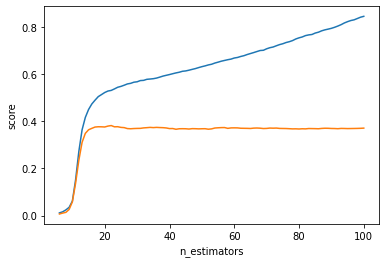

In [22]:
cv_strategy = KFold(n_splits=5)

n_trees, current_score_train, current_score_valid  = [], [], []

for i in tqdm(range(100, 5, -1)):
    estimators, oof_score_1, oof_score_2, fold_train_scores_1, fold_train_scores_2, fold_valid_scores_1, \
    fold_valid_scores_2, oof_predictions_1, oof_predictions_2, test_pred_1, test_pred_2,\
    evraz_metric_train_scores_mean, evraz_metric_valid_scores_mean = make_cross_validation(
        target_train.drop(['TST', 'C', 'DATA_ZAMERA'], axis=1), 
        target_train['TST'], 
        target_train['C'],
        test.drop(['DATA_ZAMERA'], axis=1),
        estimator_1=xgb.XGBRegressor(n_estimators=i, random_state=1), 
        estimator_2=xgb.XGBRegressor(n_estimators=i, random_state=1),
        metric=mean_squared_error, 
        cv_strategy=cv_strategy,
        error_to_be_outlier=None,
    )
    
    current_score_train.append(evraz_metric_train_scores_mean)
    current_score_valid.append(evraz_metric_valid_scores_mean)
    n_trees.append(i)

plt.plot(n_trees, current_score_train)
plt.plot(n_trees, current_score_valid)
plt.xlabel('n_estimators')
plt.ylabel('score')
plt.show();

In [19]:
cv_strategy = KFold(n_splits=5)
#cv_strategy = StratifiedKFold(n_splits=5)

n_trees=17

estimators, oof_score_1, oof_score_2, fold_train_scores_1, fold_train_scores_2, fold_valid_scores_1, \
fold_valid_scores_2, oof_predictions_1, oof_predictions_2, test_pred_1, test_pred_2,\
evraz_metric_train_scores_mean, evraz_metric_valid_scores_mean = make_cross_validation(
    target_train.drop(['TST', 'C', 'DATA_ZAMERA'], axis=1), 
    target_train['TST'], 
    target_train['C'],
    test.drop(['DATA_ZAMERA'], axis=1),
    estimator_1=xgb.XGBRegressor(n_estimators=n_trees, random_state=1), 
    estimator_2=xgb.XGBRegressor(n_estimators=n_trees, random_state=1),
    metric=mean_squared_error, 
    cv_strategy=cv_strategy,
    error_to_be_outlier=None,
)

Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 176.9663, train-score 2 = 0.0276
valid-score 1 = 587.0748, valid-score 2 = 0.1951
Train metric =  0.4942
Valid metric =  0.339
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 189.6963, train-score 2 = 0.029
valid-score 1 = 429.5158, valid-score 2 = 0.1644
Train metric =  0.4888
Valid metric =  0.3959
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 183.3585, train-score 2 = 0.025
valid-score 1 = 527.3291, valid-score 2 = 0.1872
Train metric =  0.4882
Valid metric =  0.3814
Fold: 4, train-observations = 1651, valid-observations = 412
train-score 1 = 177.2883, train-score 2 = 0.0279
valid-score 1 = 488.805, valid-score 2 = 0.1373
Train metric =  0.49
Valid metric =  0.3835
Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 181.8767, train-score 2 = 0.0343
valid-score 1 = 356.9709, valid-score 2 = 0.1607
Train metric =  0.4891
Vali

In [20]:
submit = pd.concat([test['NPLV'], 
                    pd.Series(test_pred_1).rename('TST'), 
                    pd.Series(np.exp(test_pred_2)).rename('C')
                   ],
                   axis=1
                  )
print(submit.shape)
submit.head(5)

(780, 3)


,NPLV,TST,C
0,512324,1639.152954,0.044117
1,512327,1668.477661,0.068015
2,512328,1645.428833,0.082462
3,512331,1657.093994,0.089369
4,512333,1664.839233,0.095829


In [21]:
# получаем текущие дату и время
now = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# создаём путь и имя файла с датой и временем
# file_name = f'../../data/kaggle/gb_competitive_data_analysis/lgb_predictions_{now}.csv'
file_name = f'xgb_n-tree-17_all_feats_log10_exp_metric_mse{now}.csv'
print('File name: ', file_name)

# сохраняем в csv
submit.to_csv(file_name, index=False, encoding='utf-8')
print('\n File saved to disk!')

File name:  xgb_n-tree-17_all_feats_log10_exp_metric_mse2021-11-02_21-18-44.csv

 File saved to disk!
